<a href="https://colab.research.google.com/github/Syed-Luqman-Shah-19/MIMO-Letter-GPR-Matrix-Completion/blob/main/Syed_IEEE_Letter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Codes for the letter

1.   Channels Generations, GPR based predicted channels, saving the channels
2.   Accuray of the predicted channel, error and 95% confidence tolerance for error
3. Percetage of the predicted values lies in the 95% confidence bouds
4. Channel Prediction Error (NMSE between the true and the predicted channels)


## Step 1: Channels Models generation: Kronecker and Weichselberger

In [ ]:
'''
channel_models.h5
│── Case I
│   ├── Kronecker
│   │   ├── Monte_1
│   │   │   ├── Original
│   │   │   │   ├── H (Original channel)
│   │   │   │   ├── R_H (Correlation matrix)
│   │   │   ├── RBF
│   │   │   │   ├── H (GPR prediction)
│   │   │   │   ├── std (Prediction std)
│   │   │   ├── Matern
│   │   │   ├── DotProduct
│   │   │   ├── RationalQuadratic
│   │   │   ├── ExpSineSquared
│   ├── Weichselberger
│   │   ├── Monte_1
│   │   │   ├── Original
│   │   │   │   ├── H (Original channel)
│   │   │   │   ├── R_H (Correlation matrix)
│   │   │   ├── RBF
│   │   │   ├── ...
│── Case II
│── Case III
│── Case IV
'''

import numpy as np
import pandas as pd
import h5py
from scipy.stats import norm
from sklearn.base import clone
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF, Matern, ExpSineSquared, ConstantKernel as C, DotProduct, RationalQuadratic, Kernel, Hyperparameter
)
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

from scipy.optimize import fmin_l_bfgs_b

def custom_optimizer(obj_func, initial_theta, bounds):
    opt_res = fmin_l_bfgs_b(obj_func, initial_theta, bounds=bounds, maxiter=1000)
    return opt_res[0]



# Set global random seed for reproducibility
np.random.seed(42)




class SpatialCorrelationKernel(Kernel):
    def __init__(self, R_H, Nt, scale=1.0, scale_bounds=(1e-5, 1e5)):
        self.R_H = R_H
        self.Nt = Nt
        self.scale = scale
        self.scale_bounds = scale_bounds

    @property
    def hyperparameter_scale(self):
        return Hyperparameter(
            "scale", "numeric", self.scale_bounds
        )

    @property
    def theta(self):
        return np.log([self.scale])

    @theta.setter
    def theta(self, theta):
        self.scale = np.exp(theta[0])

    @property
    def bounds(self):
        return np.log(self.scale_bounds).reshape(1, -1)

    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            Y = X

        K = np.zeros((len(X), len(Y)))
        for i, (x_i, x_j) in enumerate(X):
            idx_x = x_i * self.Nt + x_j
            for k, (y_i, y_k) in enumerate(Y):
                idx_y = y_i * self.Nt + y_k
                K[i, k] = np.real(self.R_H[idx_x, idx_y]) * self.scale

        if eval_gradient:
            dK_dtheta = K[..., np.newaxis]  # Gradient w.r.t log(scale)
            return K, dK_dtheta
        return K

    def diag(self, X):
        return np.array([np.real(self.R_H[i*self.Nt + j, i*self.Nt + j]) * self.scale
                         for (i, j) in X])

    def is_stationary(self):
        return False


####################################################
####################################################
################## Core Functions ##################
####################################################
####################################################

def planar_array_response(Y, Z, phi, theta, kd):
    m = np.arange(Y)
    n = np.arange(Z)
    phase_y = kd * m * np.sin(phi) * np.sin(theta)
    phase_z = kd * n * np.cos(theta)
    phase = np.outer(phase_y, np.ones(Z)) + np.outer(np.ones(Y), phase_z)
    a = np.exp(1j * phase).flatten()
    return a / np.linalg.norm(a)

def generate_correlation_matrix(array_dims, phi_mean, theta_mean, sigma_phi, kd, num_samples=1000): ################################################################
    Y, Z = array_dims
    N = Y * Z
    R = np.zeros((N, N), dtype=np.complex128)
    for _ in range(num_samples):
        phi = phi_mean + norm.rvs(scale=sigma_phi)
        theta = theta_mean + norm.rvs(scale=sigma_phi)
        a = planar_array_response(Y, Z, phi, theta, kd)
        R += np.outer(a, a.conj())
    R /= num_samples
    return R

################################################################
######################## Channel Models ########################
################################################################

####### Kronecker Channel Model #######
def generate_kronecker_mimo_channel(**params):
    tx_array_dims = params["tx_array_dims"]
    rx_array_dims = params["rx_array_dims"]
    num_samples = params.get("num_samples", 1000)

    Yt, Zt = tx_array_dims
    Yr, Zr = rx_array_dims
    Nt, Nr = Yt*Zt, Yr*Zr

    dx, dy, dz = np.array(params["rx_pos"]) - np.array(params["tx_pos"])
    d_2d = np.sqrt(dx**2 + dy**2)
    phi_los_tx = np.arctan2(dy, dx)
    theta_los_tx = np.arctan2(dz, d_2d)

    c = 3e8
    lambda_c = c / params["fc"]
    kd = (2 * np.pi / lambda_c) * (lambda_c / 2)

    R_tx = generate_correlation_matrix(tx_array_dims, phi_los_tx, theta_los_tx,
                                      params["sigma_phi"], kd, num_samples)
    R_rx = generate_correlation_matrix(rx_array_dims, -phi_los_tx, -theta_los_tx,
                                      params["sigma_phi"], kd, num_samples)

    R_H = np.kron(R_tx, R_rx)  # Corrected Kronecker order

    G = (np.random.randn(Nr, Nt) + 1j*np.random.randn(Nr, Nt)) / np.sqrt(2)
    L_rx = np.linalg.cholesky(R_rx + 1e-6*np.eye(Nr))
    L_tx = np.linalg.cholesky(R_tx + 1e-6*np.eye(Nt))
    H = L_rx @ G @ L_tx.T

    return H, R_H

####### Weichselberger Channel Model #######
def generate_weichselberger_mimo_channel(**params):
    tx_array_dims = params["tx_array_dims"]
    rx_array_dims = params["rx_array_dims"]
    num_samples = params.get("num_samples", 1000)

    Yt, Zt = tx_array_dims
    Yr, Zr = rx_array_dims
    Nt, Nr = Yt*Zt, Yr*Zr

    R_rx = np.zeros((Nr, Nr), dtype=np.complex128)
    R_tx = np.zeros((Nt, Nt), dtype=np.complex128)

    num = 100;
    for _ in range(num):
        H_kron, _ = generate_kronecker_mimo_channel(**params)
        R_rx += H_kron @ H_kron.conj().T
        R_tx += H_kron.conj().T @ H_kron

    R_rx /= num
    R_tx /= num

    S_rx, U_rx = np.linalg.eigh(R_rx)
    S_tx, U_tx = np.linalg.eigh(R_tx)

    S_rx = np.real(S_rx).clip(min=0)
    S_tx = np.real(S_tx).clip(min=0)

    omega = np.outer(S_rx, S_tx)
    omega /= np.sum(omega)

    U_kron = np.kron(U_tx, U_rx)
    R_H = U_kron @ np.diag(omega.flatten()) @ U_kron.conj().T

    G = (np.random.randn(Nr, Nt) + 1j*np.random.randn(Nr, Nt)) / np.sqrt(2)
    H = U_rx @ (np.sqrt(omega) * G) @ U_tx.conj().T

    return H, R_H

###################################################################
######################## System Parameters ########################
###################################################################
common_params = {
    "tx_array_dims": (2, 2),
    "rx_array_dims": (2, 2),
    "fc": 28e9,
    "tx_pos": (0, 0, 0),
    "rx_pos": (20, 5, 1.5),
    "sigma_phi": np.pi/6
}

def extract_training_data(H, case):
    case_indices = {
        "Case I": [(0, 0)],
        "Case II": [(0, 0), (0, 1), (1, 0), (1, 1)],
        "Case III": [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (2, 2), (2, 0), (2, 1), (2, 2)],
        "Case IV":  [(0, 0), (1, 1), (2, 2), (3, 3)]
    }
    indices = case_indices[case]
    X_train = np.array(indices)
    y_train_real = np.array([H[i, j].real for i, j in indices])
    y_train_imag = np.array([H[i, j].imag for i, j in indices])
    return X_train, y_train_real, y_train_imag


def generate_and_store_channels(num_monte=1000, filename='channel_models.h5'):
    case_indices = {
        "Case I": [(0, 0)],
        "Case II": [(0, 0), (0, 1), (1, 0), (1, 1)],
        "Case III": [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (2, 2), (2, 0), (2, 1), (2, 2)],
        "Case IV":  [(0, 0), (1, 1), (2, 2), (3, 3)]
    }
    cases = list(case_indices.keys())

    base_kernels = {
        'RBF': 1.0 * RBF(length_scale=0.5, length_scale_bounds=(0.01, 10.0)),
        'Matern': 1.0 * Matern(length_scale=0.5, nu=1.5, length_scale_bounds=(0.01, 10.0)),
        #'DotProduct': C(1.0, (0.1, 20.0)) * DotProduct(sigma_0=0.1, sigma_0_bounds=(0.01, 1.0)),
        'RationalQuadratic': C(1.0, (0.1, 10.0)) * RationalQuadratic(length_scale=0.5, alpha=0.5, length_scale_bounds=(0.01, 5.0), alpha_bounds=(0.1, 5.0)),
        #'ExpSineSquared': C(1.0, (0.1, 10.0)) * ExpSineSquared(length_scale=0.5, periodicity=np.pi/2, length_scale_bounds=(0.01, 5.0), periodicity_bounds=(np.pi/4, np.pi))
    }

    models = ['Kronecker', 'Weichselberger']

    with h5py.File(filename, 'w') as hf:
        # Initialize storage structure
        storage = {
            case: {
                model: {
                    'Original': {'H': [], 'R_H': []},
                    **{kname: {'H': [], 'std': []} for kname in base_kernels},
                    'SpatialCorrelation': {'H': [], 'std': []}
                } for model in models
            } for case in cases
        }

        for _ in range(num_monte):
            for model in models:
                # Common parameters and model generation
                params = {
                    **common_params,
                    "num_samples": 1000,
                    "seed": 42  # Fixed seed for reproducibility
                }
                H, R_H = globals()[f"generate_{model.lower()}_mimo_channel"](**params)


                Nr, Nt = H.shape

                for case in cases:
                    # Extract training data for this case
                    X_train, y_train_real, y_train_imag = extract_training_data(H, case)
                    #X_all = np.array([(i, j) for i in range(Nr) for j in range(Nt)])
                    X_all = np.array([(rx_idx, tx_idx) for rx_idx in range(Nr) for tx_idx in range(Nt)])



                    # Store original channel data for this case, model, and iteration
                    storage[case][model]['Original']['H'].append(H)
                    storage[case][model]['Original']['R_H'].append(R_H)

                    # Process each base kernel
                    for kernel_name in base_kernels:
                        kernel = clone(base_kernels[kernel_name])

                        # Real part prediction
                        gpr_real = GaussianProcessRegressor(
                            kernel=kernel, n_restarts_optimizer=10,
                            optimizer='fmin_l_bfgs_b', random_state=0
                        )
                        gpr_real.fit(X_train, y_train_real)
                        print(f'The kernel fitted to the real part prediction is: {gpr_real.kernel_}')
                        y_pred_real, std_real = gpr_real.predict(X_all, return_std=True)

                        # Imaginary part prediction
                        gpr_imag = GaussianProcessRegressor(
                            kernel=kernel, n_restarts_optimizer=10,
                            optimizer='fmin_l_bfgs_b', random_state=0
                        )
                        gpr_imag.fit(X_train, y_train_imag)
                        print(f'The kernel fitted to the imaginary part prediction is: {gpr_imag.kernel_}')
                        y_pred_imag, std_imag = gpr_imag.predict(X_all, return_std=True)

                        # Store results
                        H_gpr = (y_pred_real + 1j*y_pred_imag).reshape(Nr, Nt)
                        total_std = np.sqrt(std_real**2 + std_imag**2).reshape(Nr, Nt)
                        storage[case][model][kernel_name]['H'].append(H_gpr)
                        storage[case][model][kernel_name]['std'].append(total_std)

                    # Process SpatialCorrelation kernel
                    kernel = SpatialCorrelationKernel(R_H, Nt, scale=0.5)
                    gpr_real = GaussianProcessRegressor(
                        kernel=kernel, n_restarts_optimizer=10,
                        optimizer='fmin_l_bfgs_b', random_state=0
                    )
                    gpr_real.fit(X_train, y_train_real)
                    print(f'The kernel fitted to the real part prediction is: {gpr_real.kernel_}')
                    y_pred_real, std_real = gpr_real.predict(X_all, return_std=True)

                    gpr_imag = GaussianProcessRegressor(
                        kernel=kernel, n_restarts_optimizer=10,
                        optimizer='fmin_l_bfgs_b', random_state=0
                    )
                    gpr_imag.fit(X_train, y_train_imag)
                    print(f'The kernel fitted to the imaginary part prediction is: {gpr_imag.kernel_}')
                    y_pred_imag, std_imag = gpr_imag.predict(X_all, return_std=True)

                    H_gpr = (y_pred_real + 1j*y_pred_imag).reshape(Nr, Nt)
                    total_std = np.sqrt(std_real**2 + std_imag**2).reshape(Nr, Nt)
                    storage[case][model]['SpatialCorrelation']['H'].append(H_gpr)
                    storage[case][model]['SpatialCorrelation']['std'].append(total_std)

        # Save all data to HDF5
        for case in cases:
            case_grp = hf.create_group(case)
            for model in models:
                model_grp = case_grp.create_group(model)
                current_storage = storage[case][model]
                for category in current_storage:
                    grp = model_grp.create_group(category)
                    if 'H' in current_storage[category]:
                        grp.create_dataset('H', data=np.array(current_storage[category]['H'], dtype=np.complex128))
                    if 'std' in current_storage[category]:
                        grp.create_dataset('std', data=np.array(current_storage[category]['std']))
                    if 'R_H' in current_storage[category]:
                        grp.create_dataset('R_H', data=np.array(current_storage[category]['R_H'], dtype=np.complex128))

generate_and_store_channels(num_monte=1000)
print('The data is successfully Generated and Saved')

## Step 2: Error in the predicted and actual channel entries
1. Error is measured between the actual and predicted channel complex entries.
2. 95% confidence bounds that shows how much error can be tolerated.

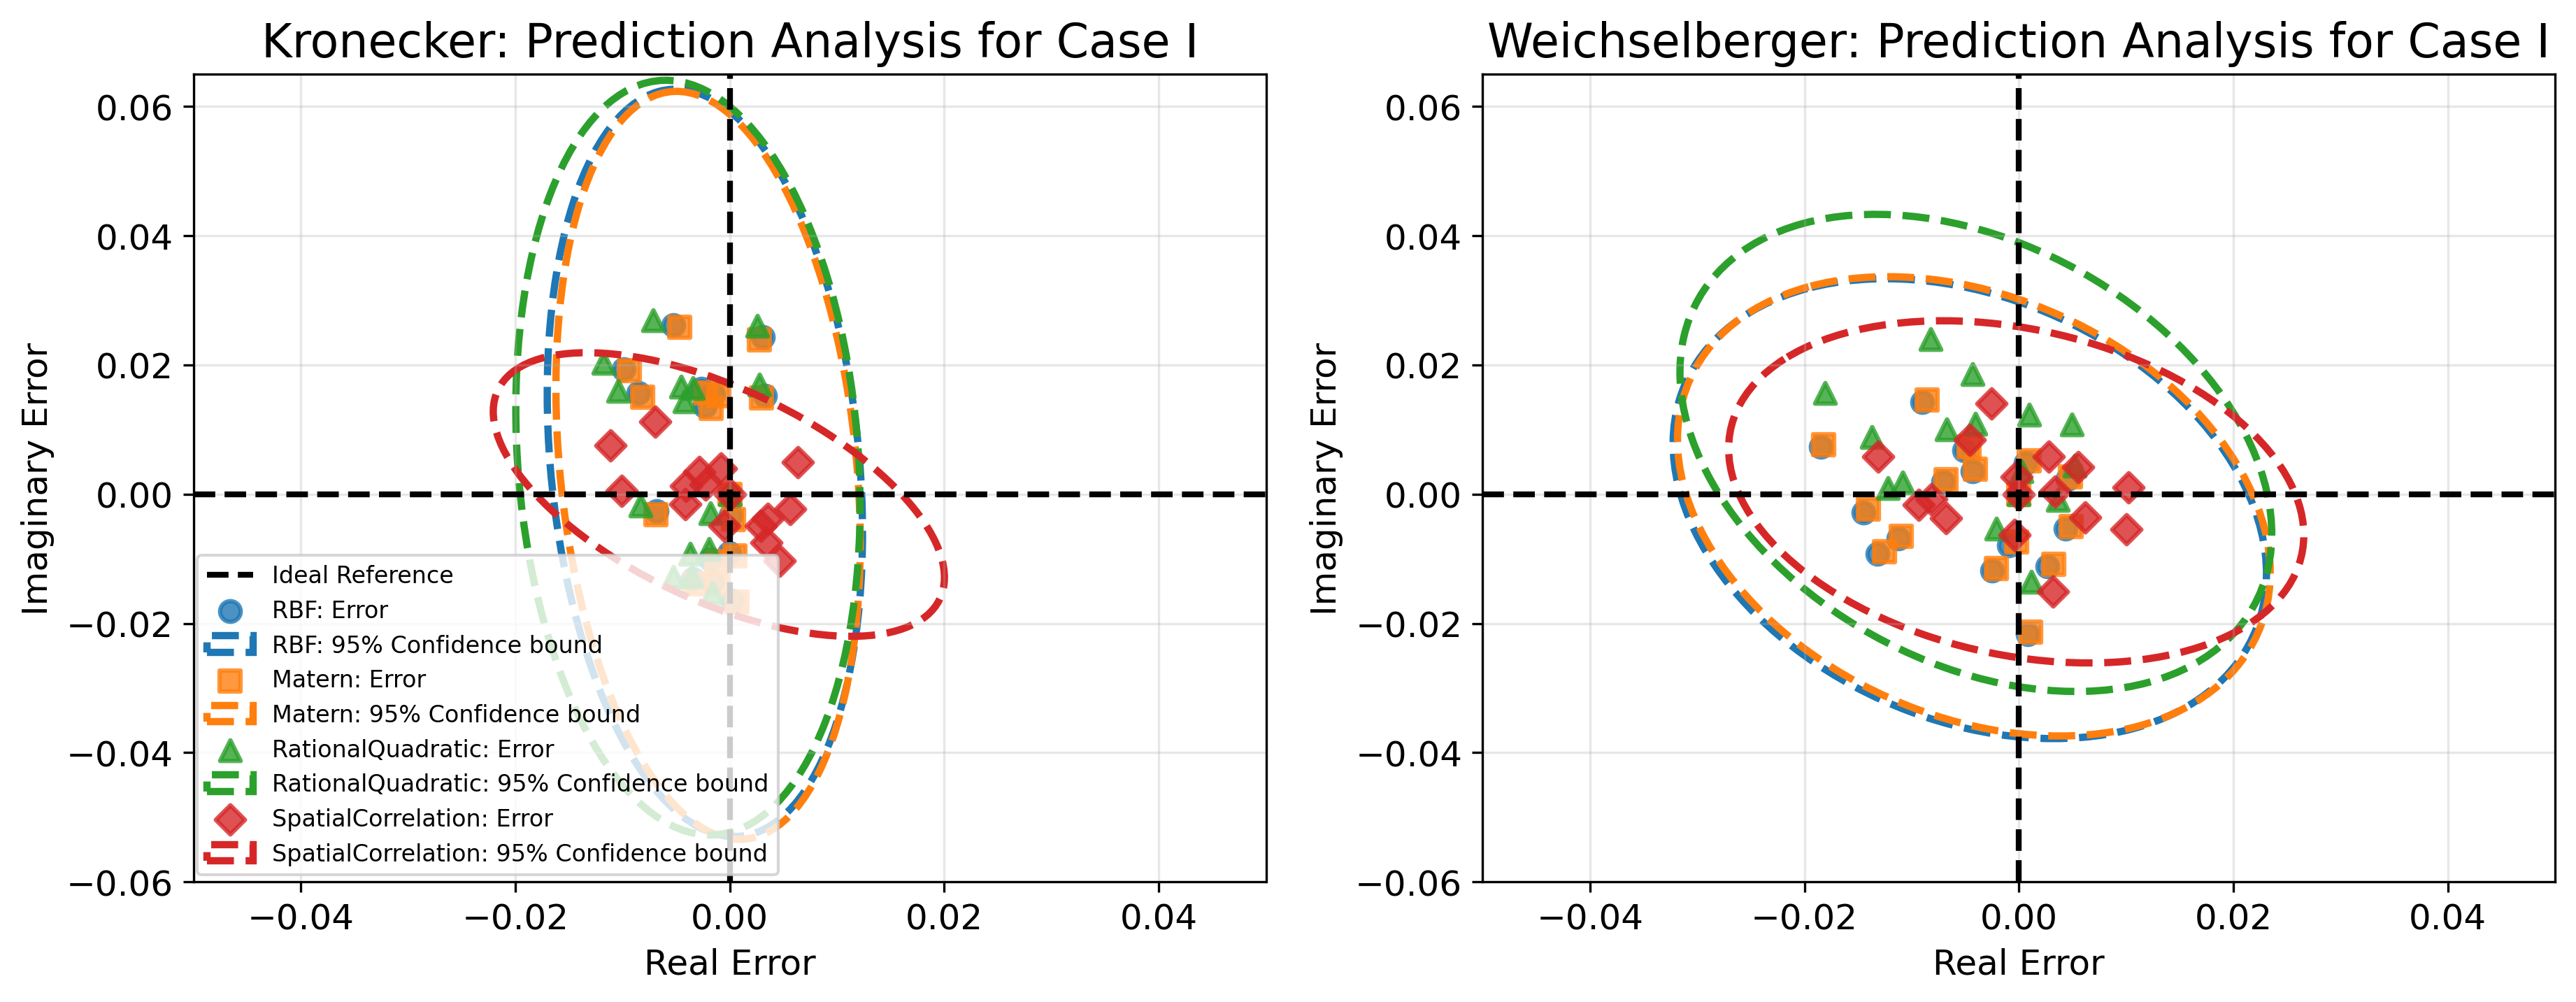

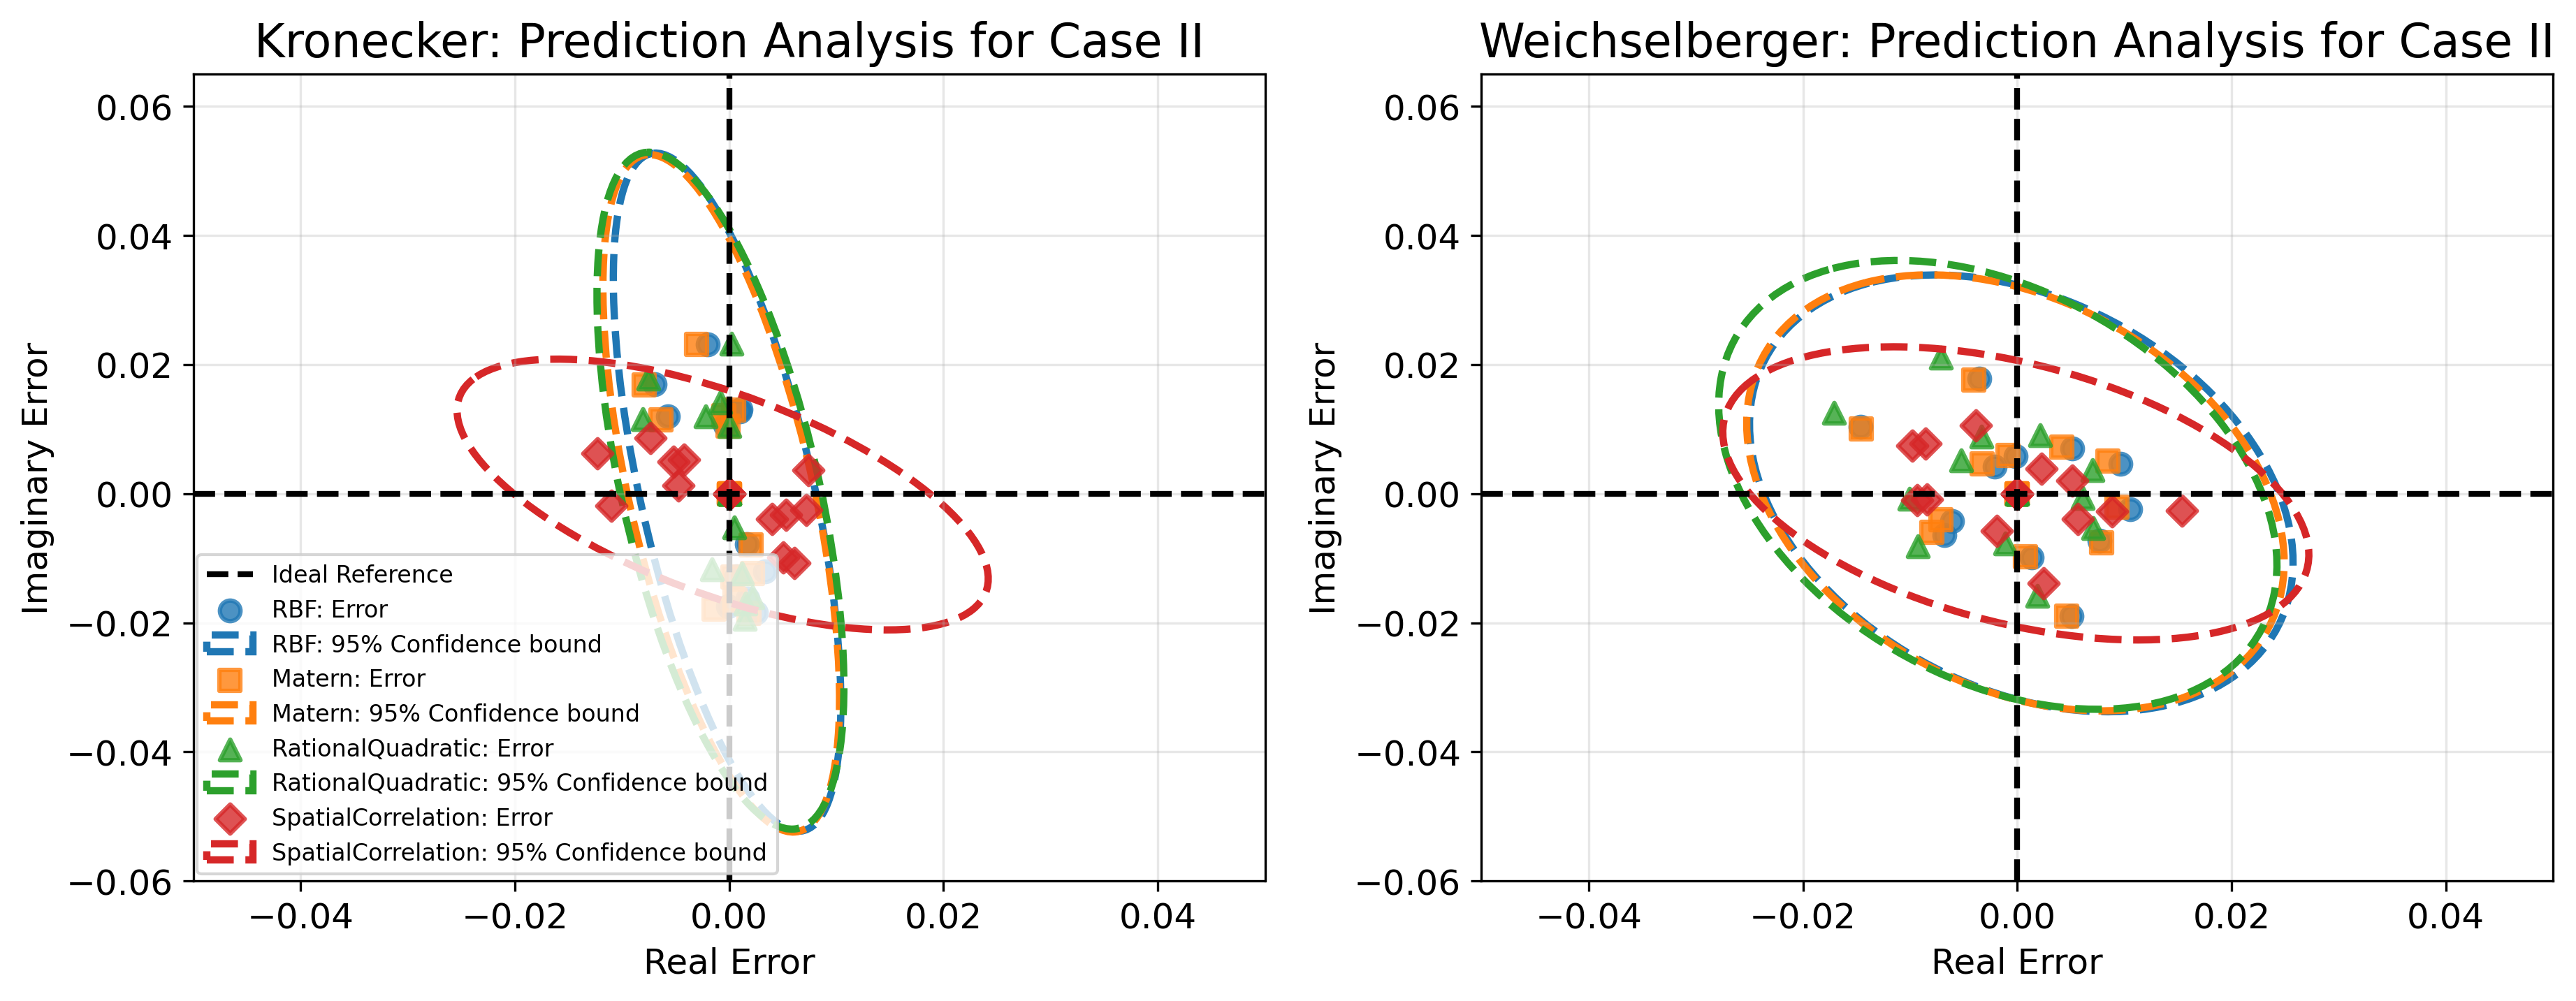

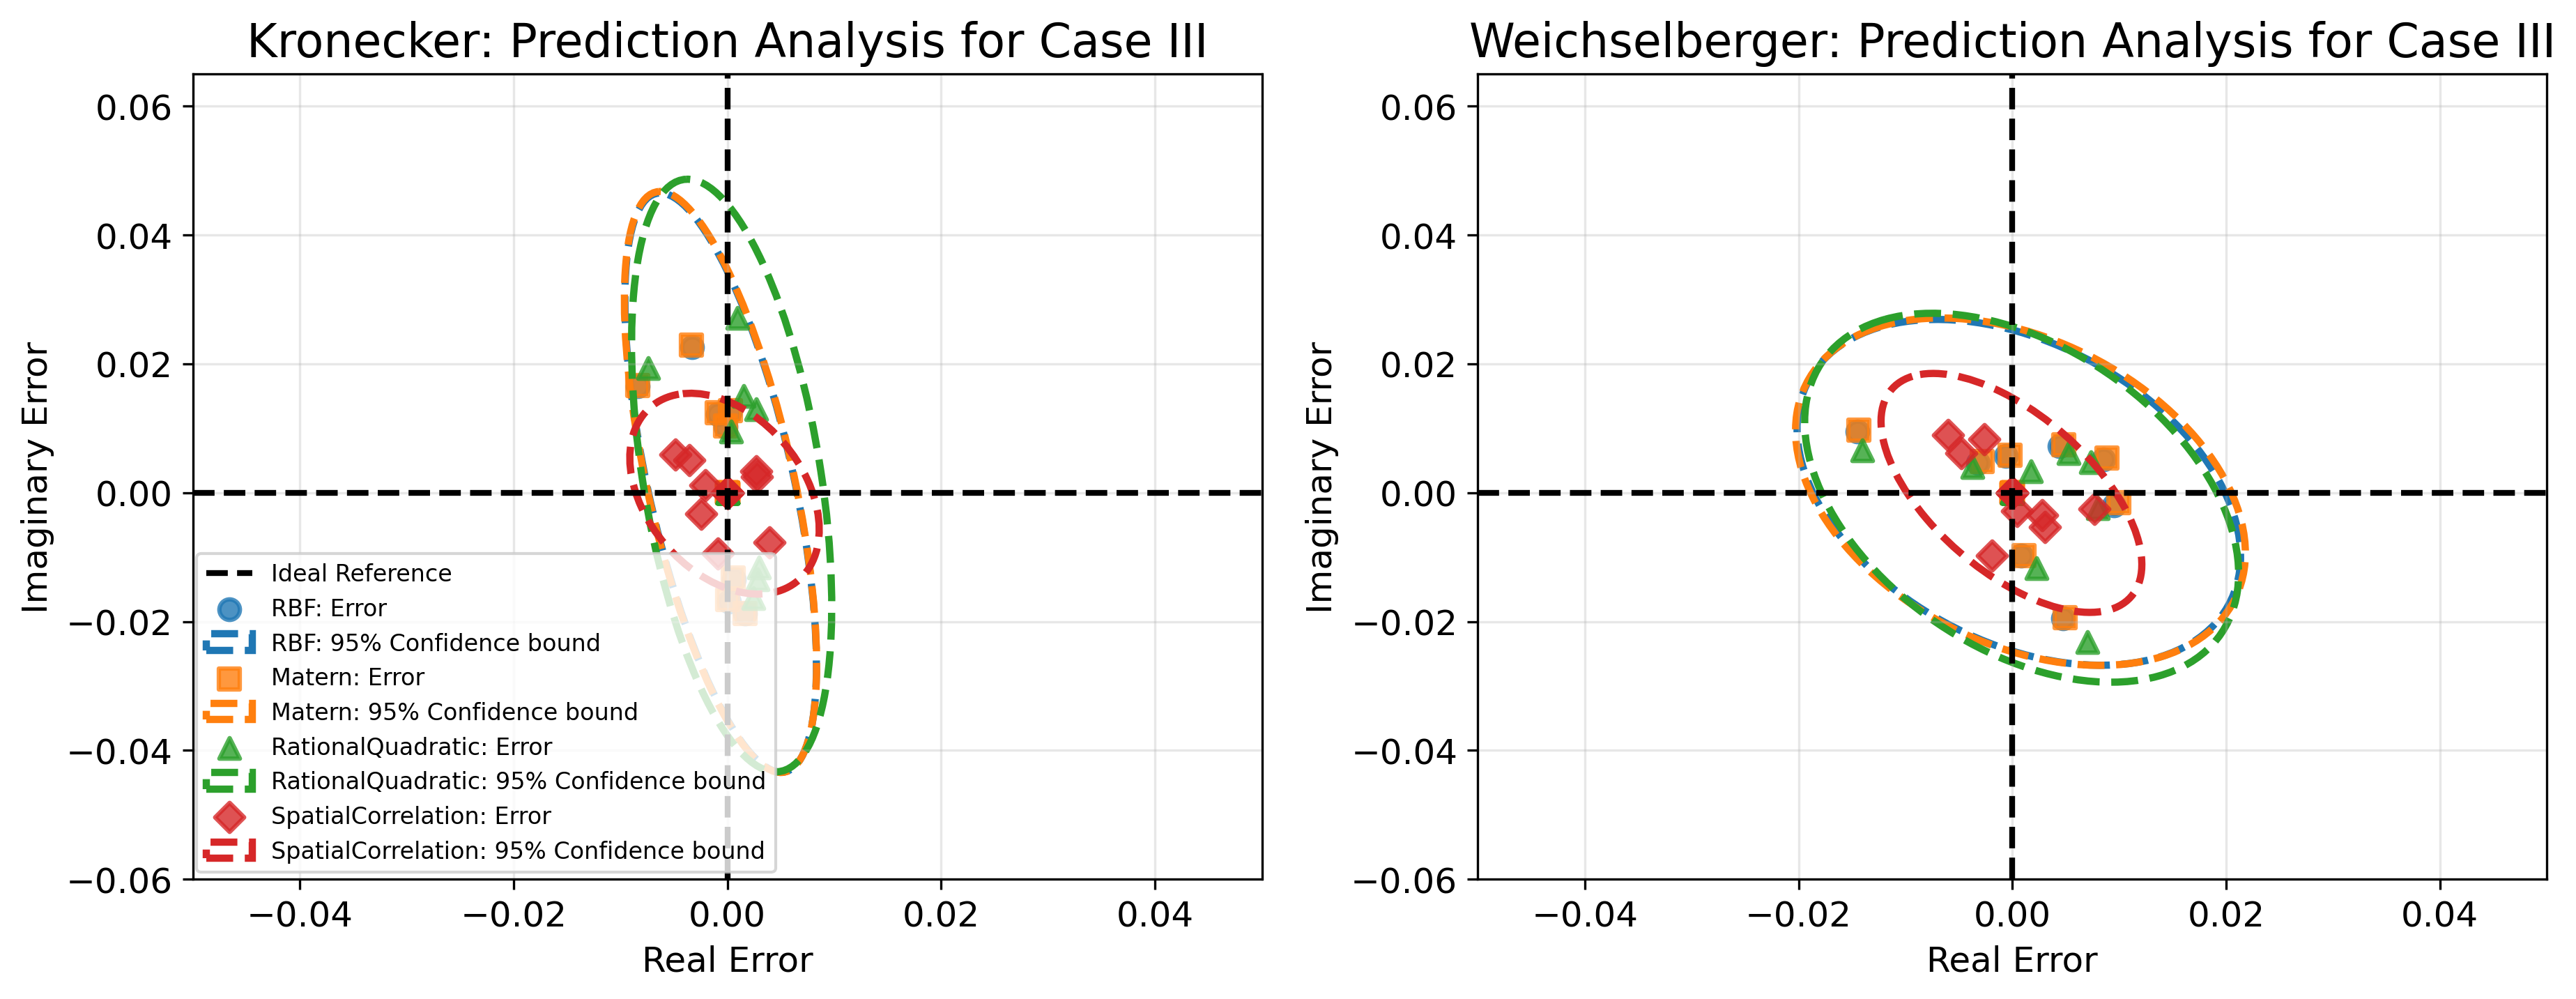

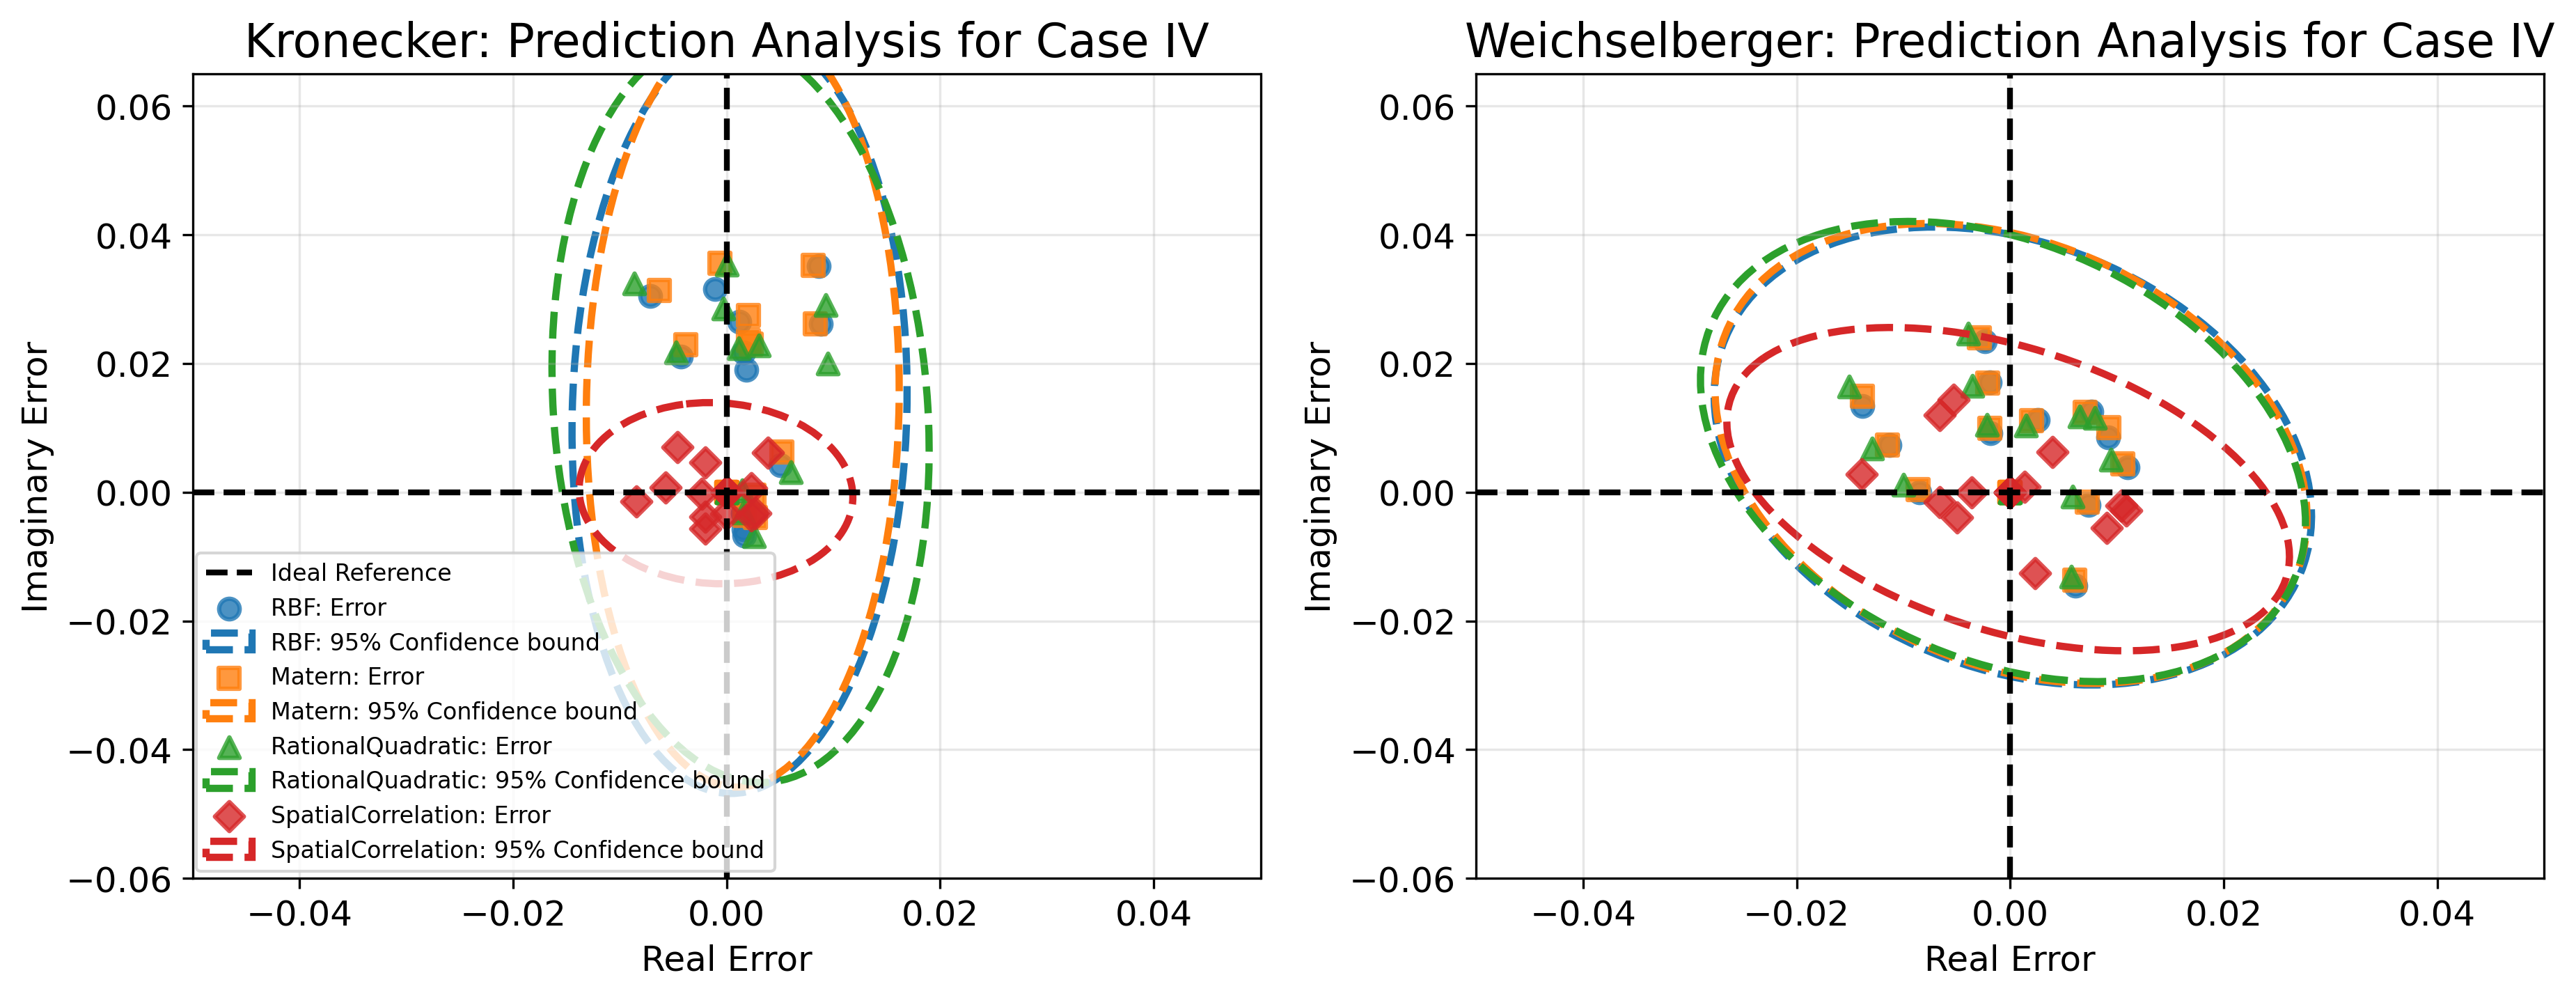

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Configuration
cases = ["Case I", "Case II", "Case III", "Case IV"]
models = ["Kronecker", "Weichselberger"]
kernels = ['RBF', 'Matern','RationalQuadratic','SpatialCorrelation']
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'axes.grid': True,
    'grid.alpha': 0.3
})

colors = plt.cm.tab10.colors
markers = ['o', 's', '^', 'D', 'v', 'p']  # Different markers for each kernel

def plot_complex_comparison():
    with h5py.File('channel_models.h5', 'r') as f:
        for case in cases:
            #fig, axs = plt.subplots(1, 2, figsize=(20, 8))
            fig, axs = plt.subplots(1, 2, figsize=(12.5, 5))
            #fig.suptitle(f'{case} - Complex MIMO Channel Prediction Analysis', y=1.05, fontsize=16)

            for model_idx, model in enumerate(models):
                ax = axs[model_idx]
                H_true = np.mean(f[case][model]['Original']['H'][:], axis=0)

                # Plot ideal reference (axes at zero)
                ax.axhline(0, color='black', linestyle='--', lw=2, label='Ideal Reference')
                ax.axvline(0, color='black', linestyle='--', lw=2)

                for kernel_idx, kernel in enumerate(kernels):
                    # Get predictions and uncertainties
                    H_pred = np.mean(f[case][model][kernel]['H'][:], axis=0)
                    std = np.mean(f[case][model][kernel]['std'][:], axis=0)

                    # Calculate complex errors
                    error = (H_pred - H_true).flatten()
                    real_err = np.real(error)
                    imag_err = np.imag(error)

                    # Plot individual errors with unique markers
                    #ax.scatter(real_err, imag_err, s=100, alpha=0.8, color=colors[kernel_idx], marker=markers[kernel_idx], edgecolor='black', linewidth=1.5, label=f'{kernel}: Error')
                    ax.scatter(real_err, imag_err, s=50, alpha=0.8, color=colors[kernel_idx], marker=markers[kernel_idx], linewidth=1.5, label=f'{kernel}: Error')

                    # Add confidence ellipse
                    cov = np.cov(real_err, imag_err)
                    lambda_, v = np.linalg.eigh(cov)
                    lambda_ = np.sqrt(lambda_)
                    ell = Ellipse(xy=(np.mean(real_err), np.mean(imag_err)),
                                  width=lambda_[0] * 4 * 1.96,  # 95% CI
                                  height=lambda_[1] * 4 * 1.96,
                                  angle=np.degrees(np.arctan2(*v[:, 0][::-1])),
                                  color=colors[kernel_idx],
                                  fc='None', lw=2.5, linestyle='--', label=f'{kernel}: 95% Confidence bound')
                    ax.add_patch(ell)

                ax.set_xlabel('Real Error', fontsize=12)
                ax.set_ylabel('Imaginary Error', fontsize=12)
                ax.set_title(f'{model}: Prediction Analysis for {case}')
                ax.grid(True)
                ax.set_xlim(-0.05, 0.05)
                ax.set_ylim(-0.06, 0.065)
                #ax.set_xlim(-1, 1)
                #ax.set_ylim(-1, 1)

            # Create unified legend for all elements
            handles, labels = axs[0].get_legend_handles_labels()
            #handles2, labels2 = axs[1].get_legend_handles_labels()
            #fig.legend(handles + handles2, labels + labels2, loc='upper right', ncol=2, bbox_to_anchor=(0.985, 0.2))
            fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(0.31, 0.459), fontsize=8)

            plt.tight_layout()
            plt.savefig(f'Complex_Comparison_{case.replace(" ", "")}.pdf',
                        dpi=300, bbox_inches='tight')
            plt.show()

if __name__ == "__main__":
    plot_complex_comparison()

## Step 3:

1.   How much percentage of the predicted complex values lies inside in the 95% confidence.

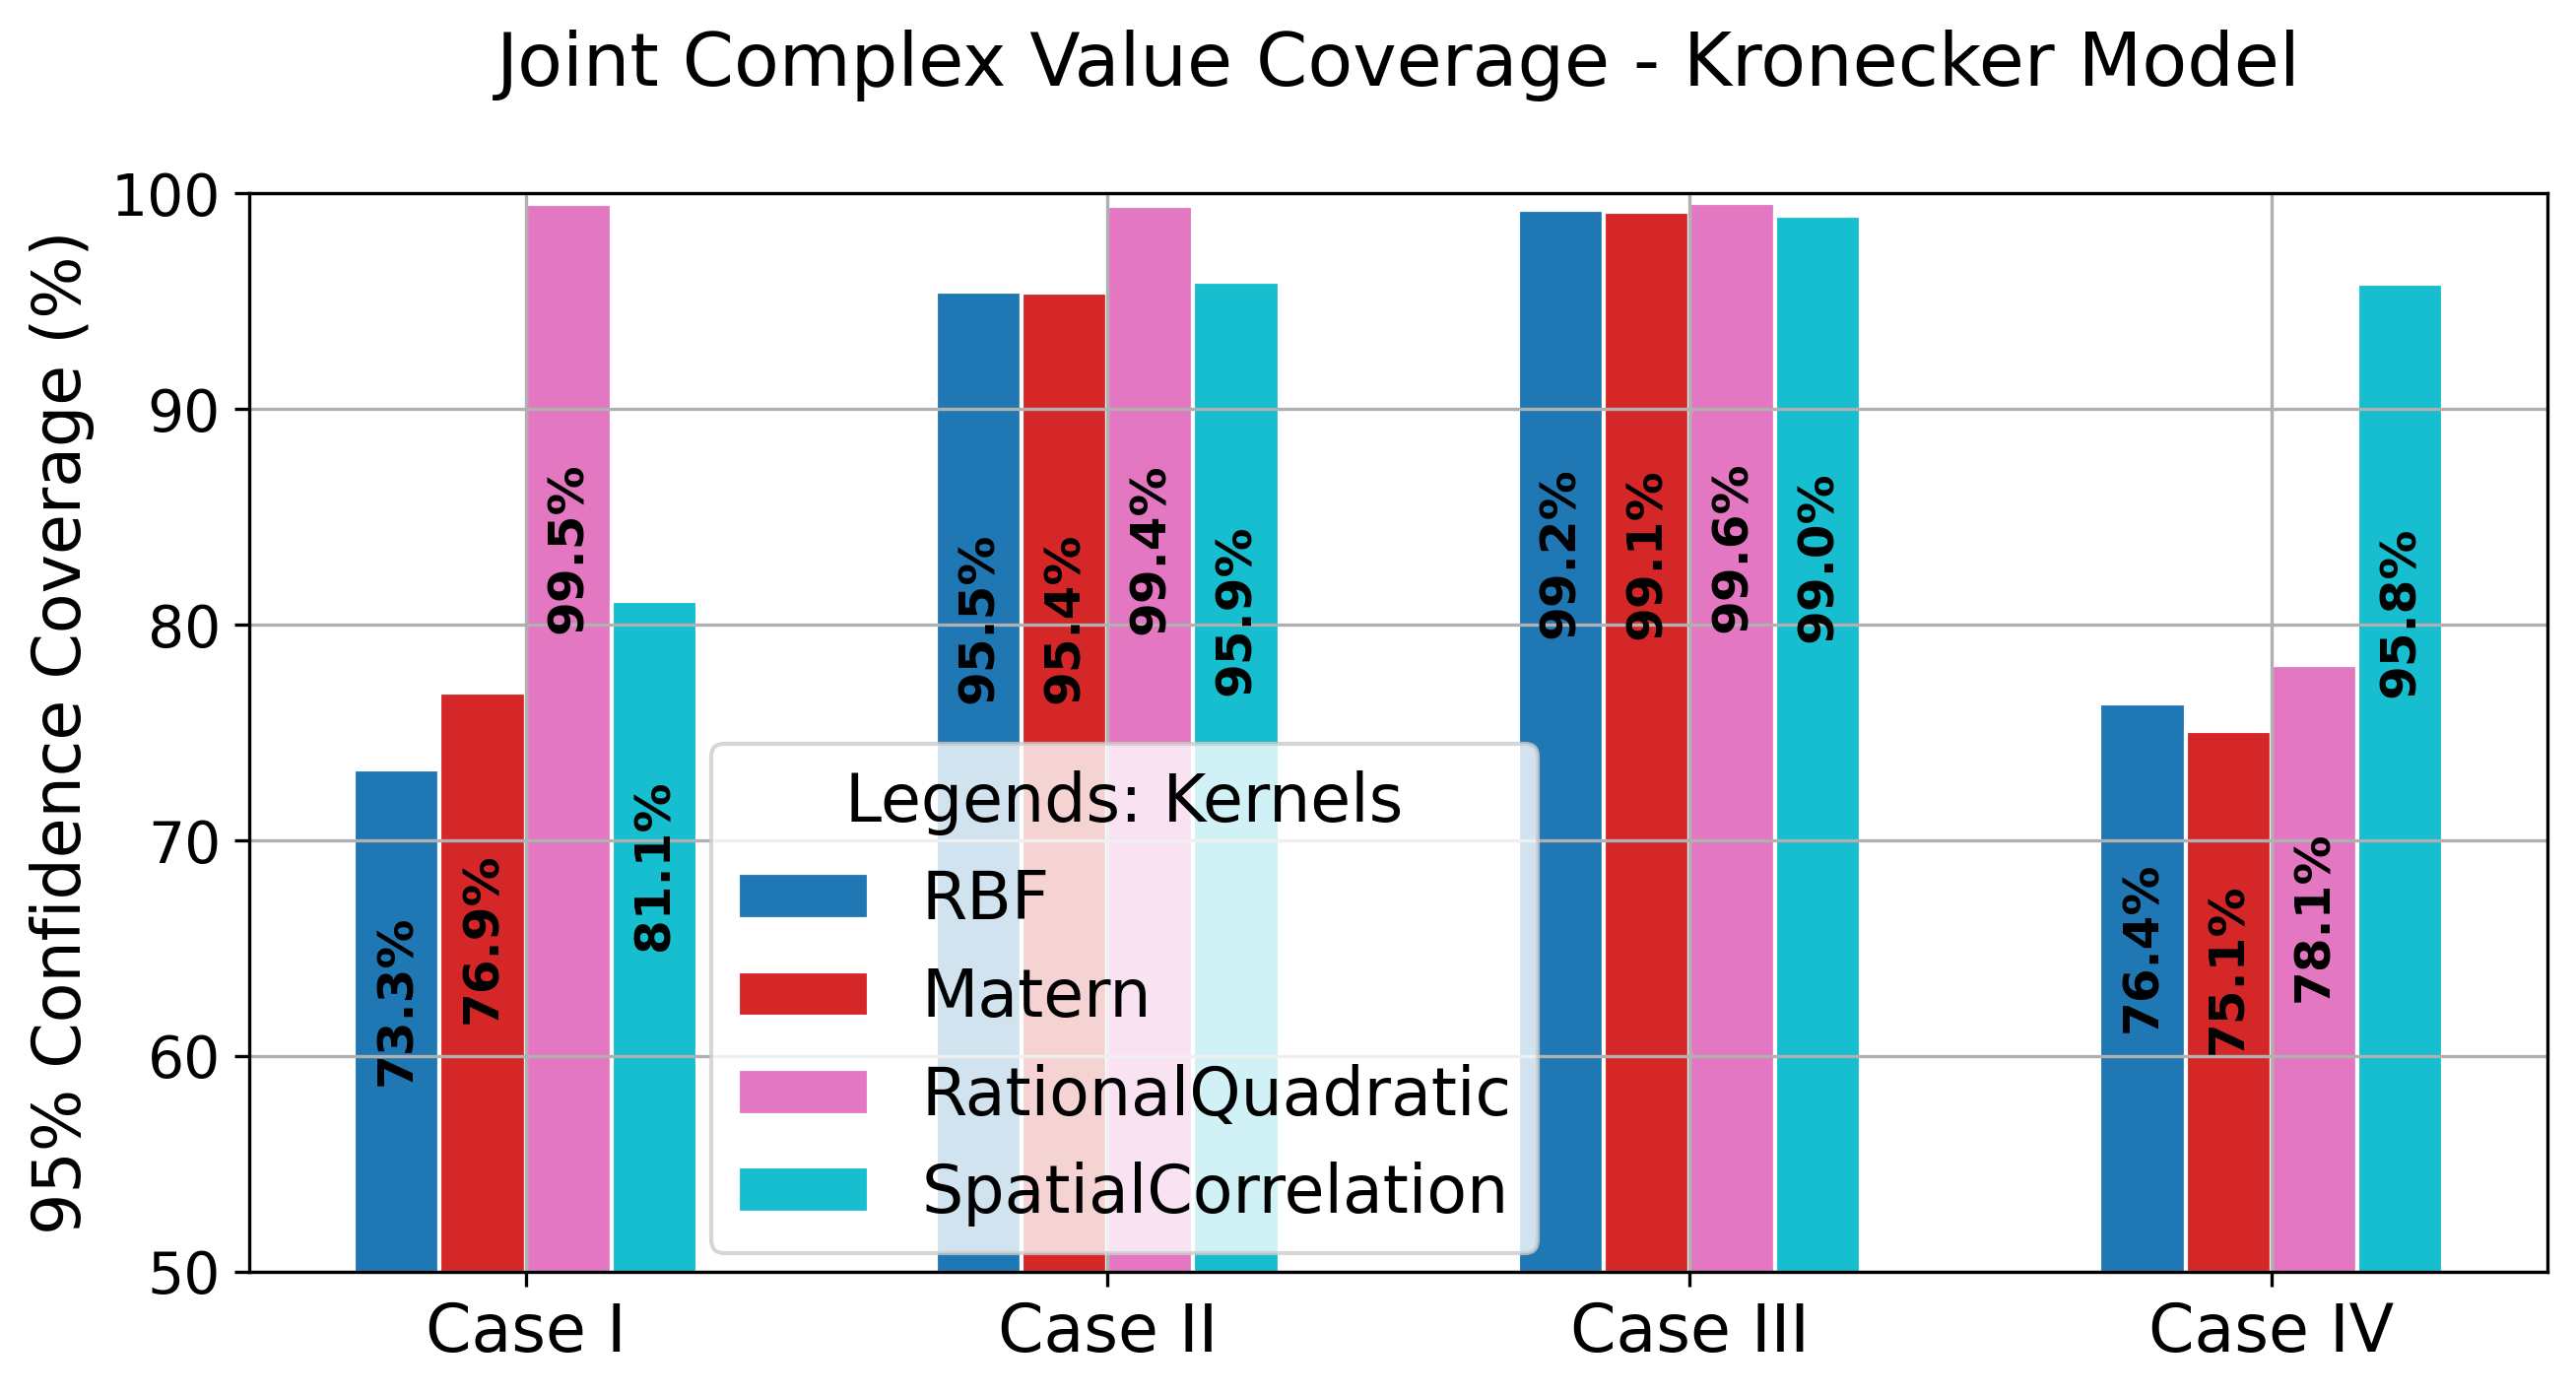

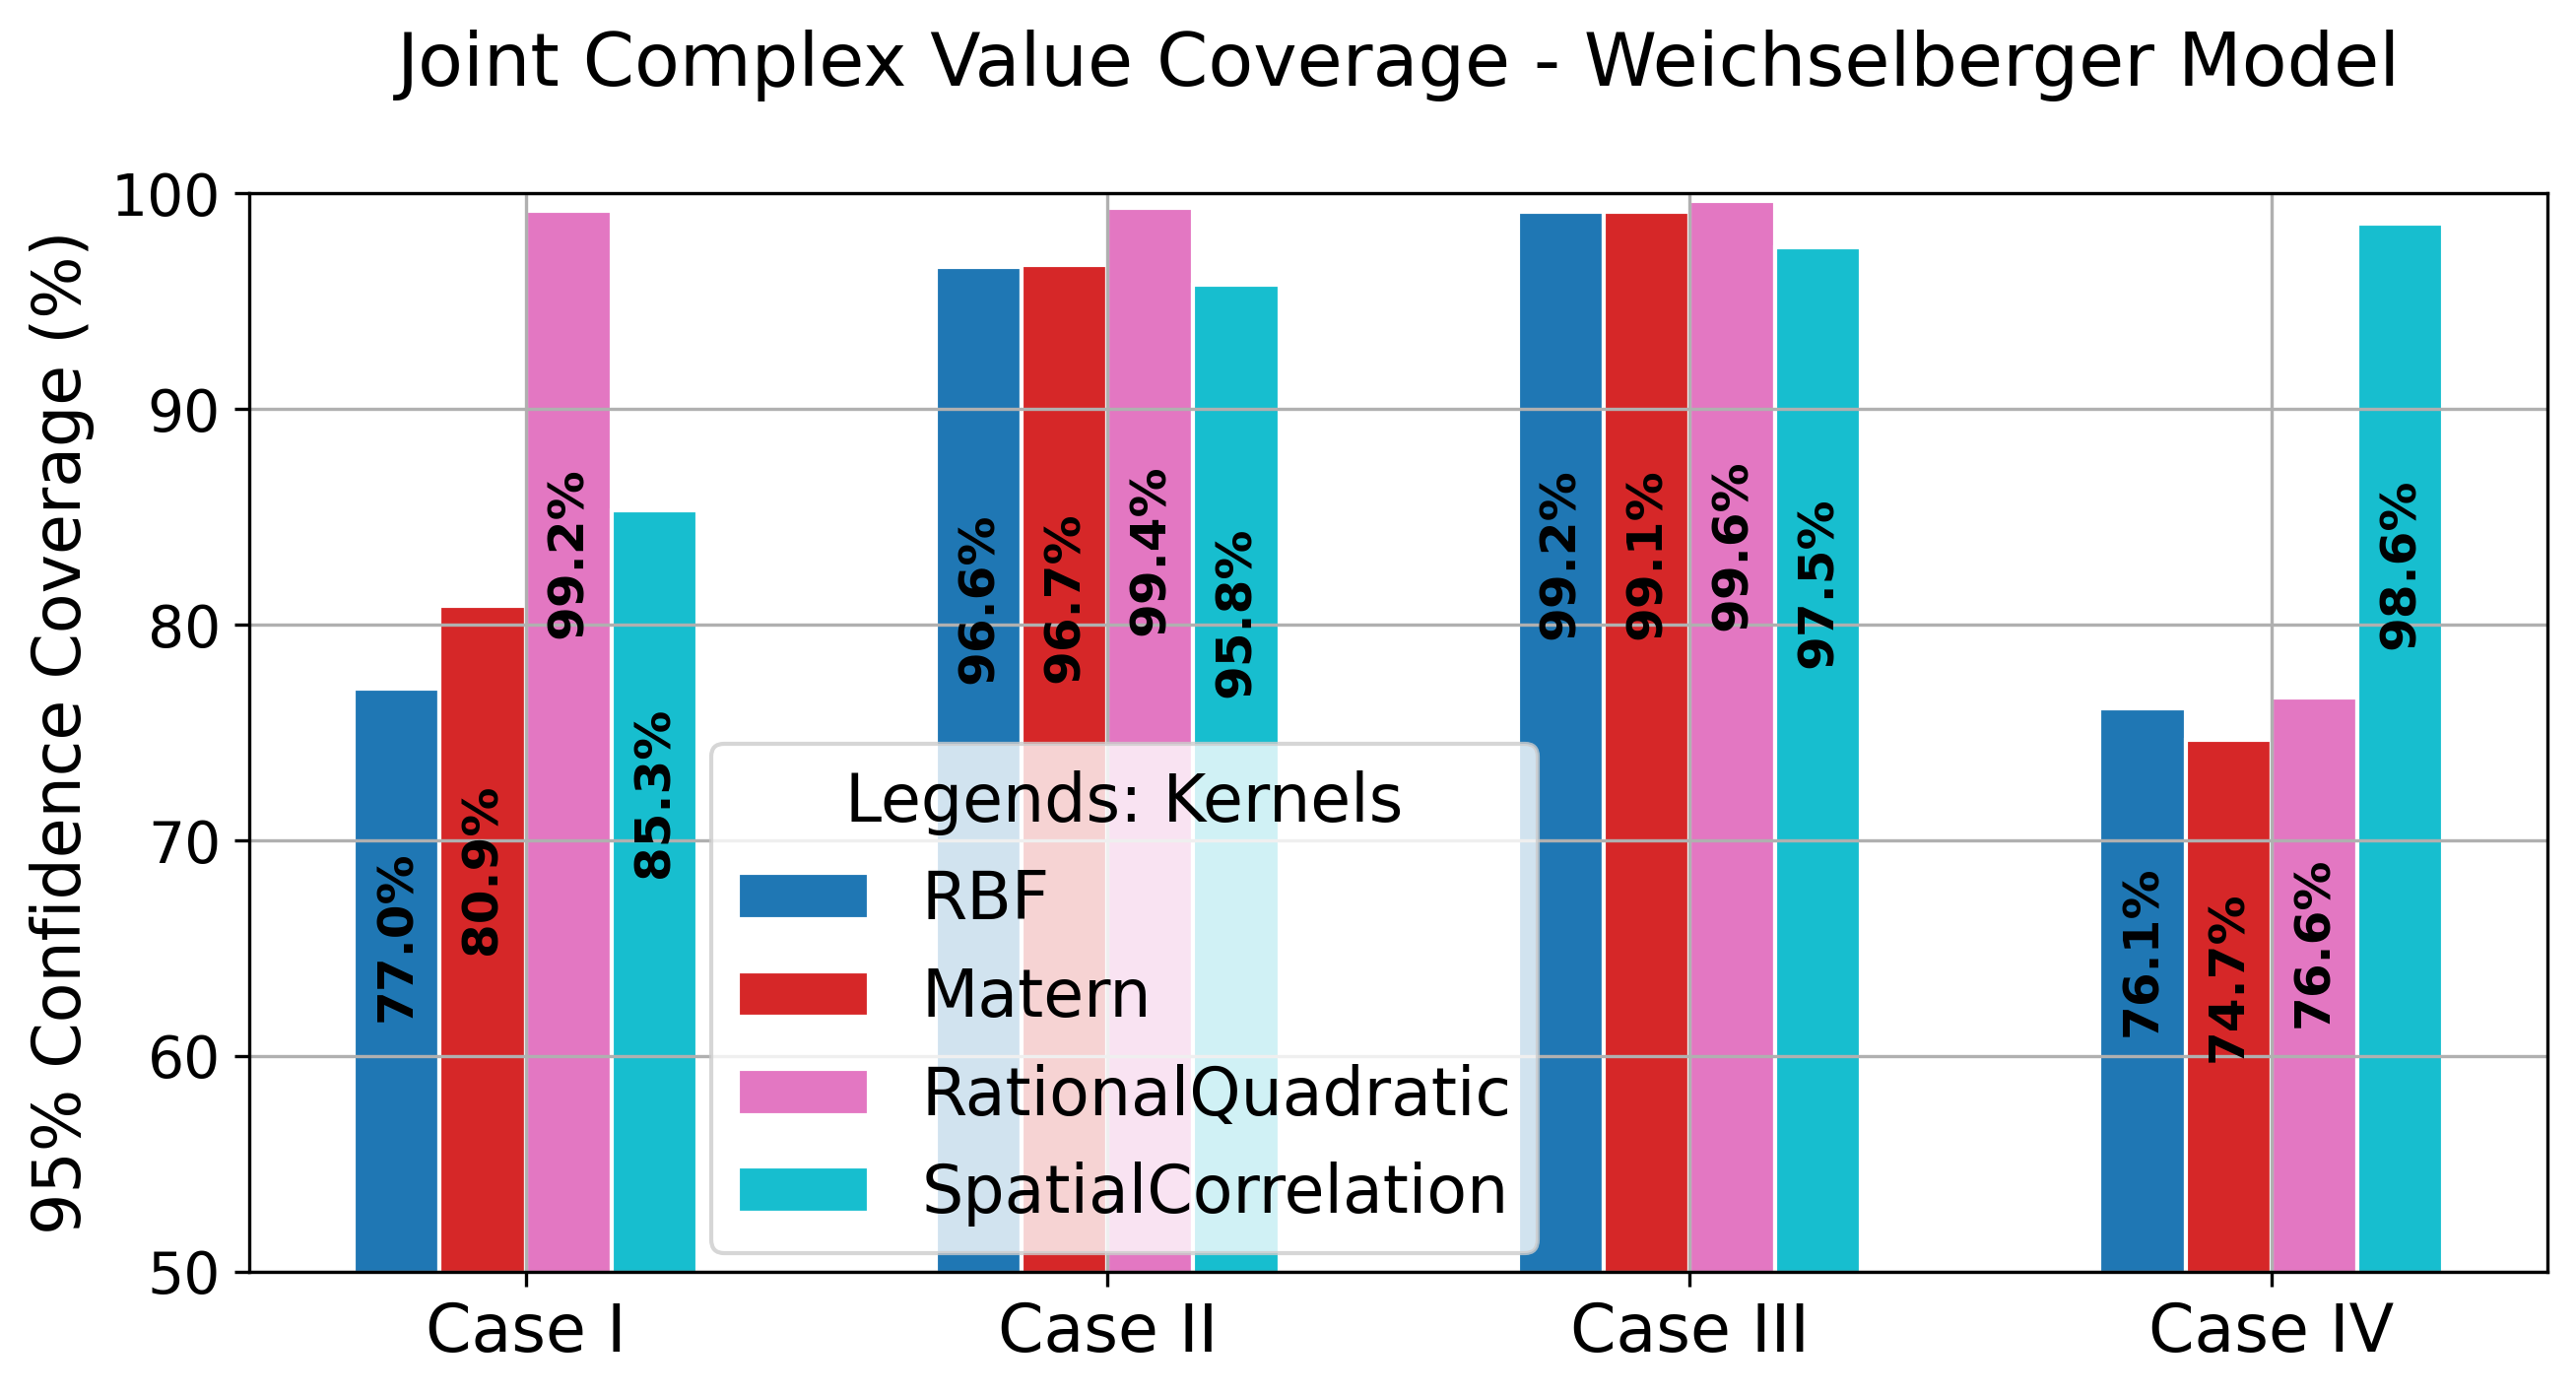

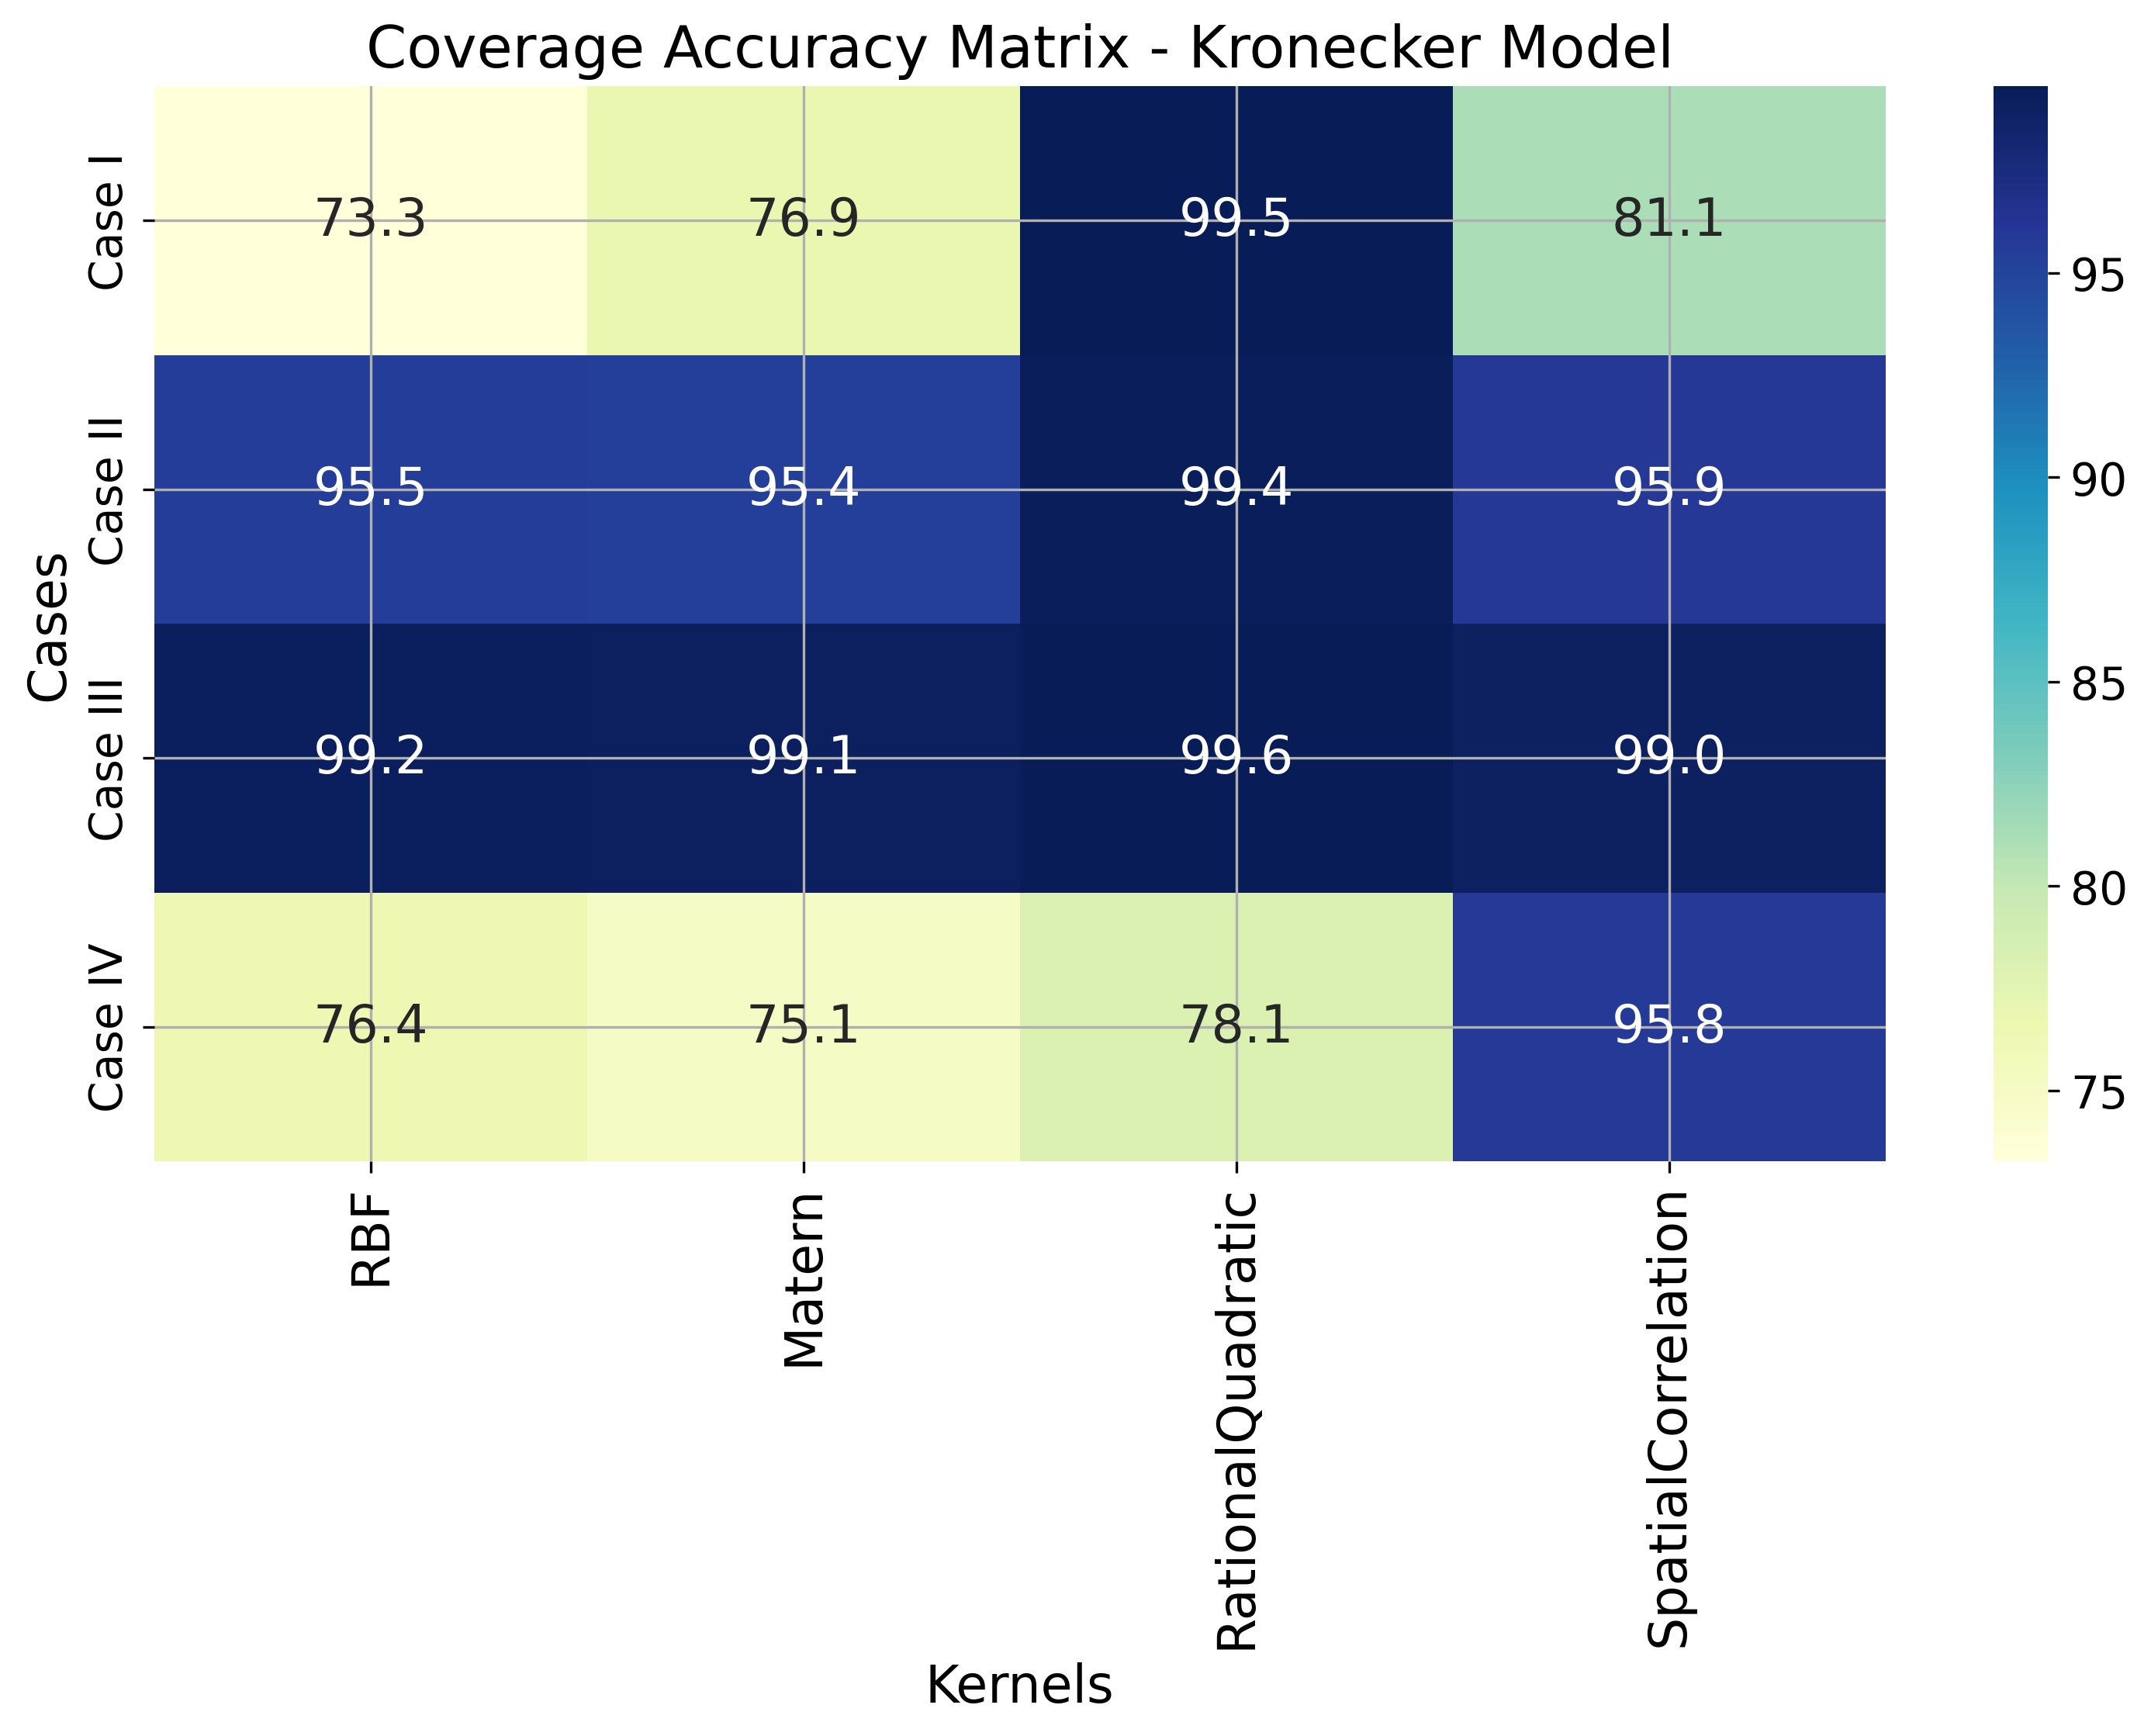

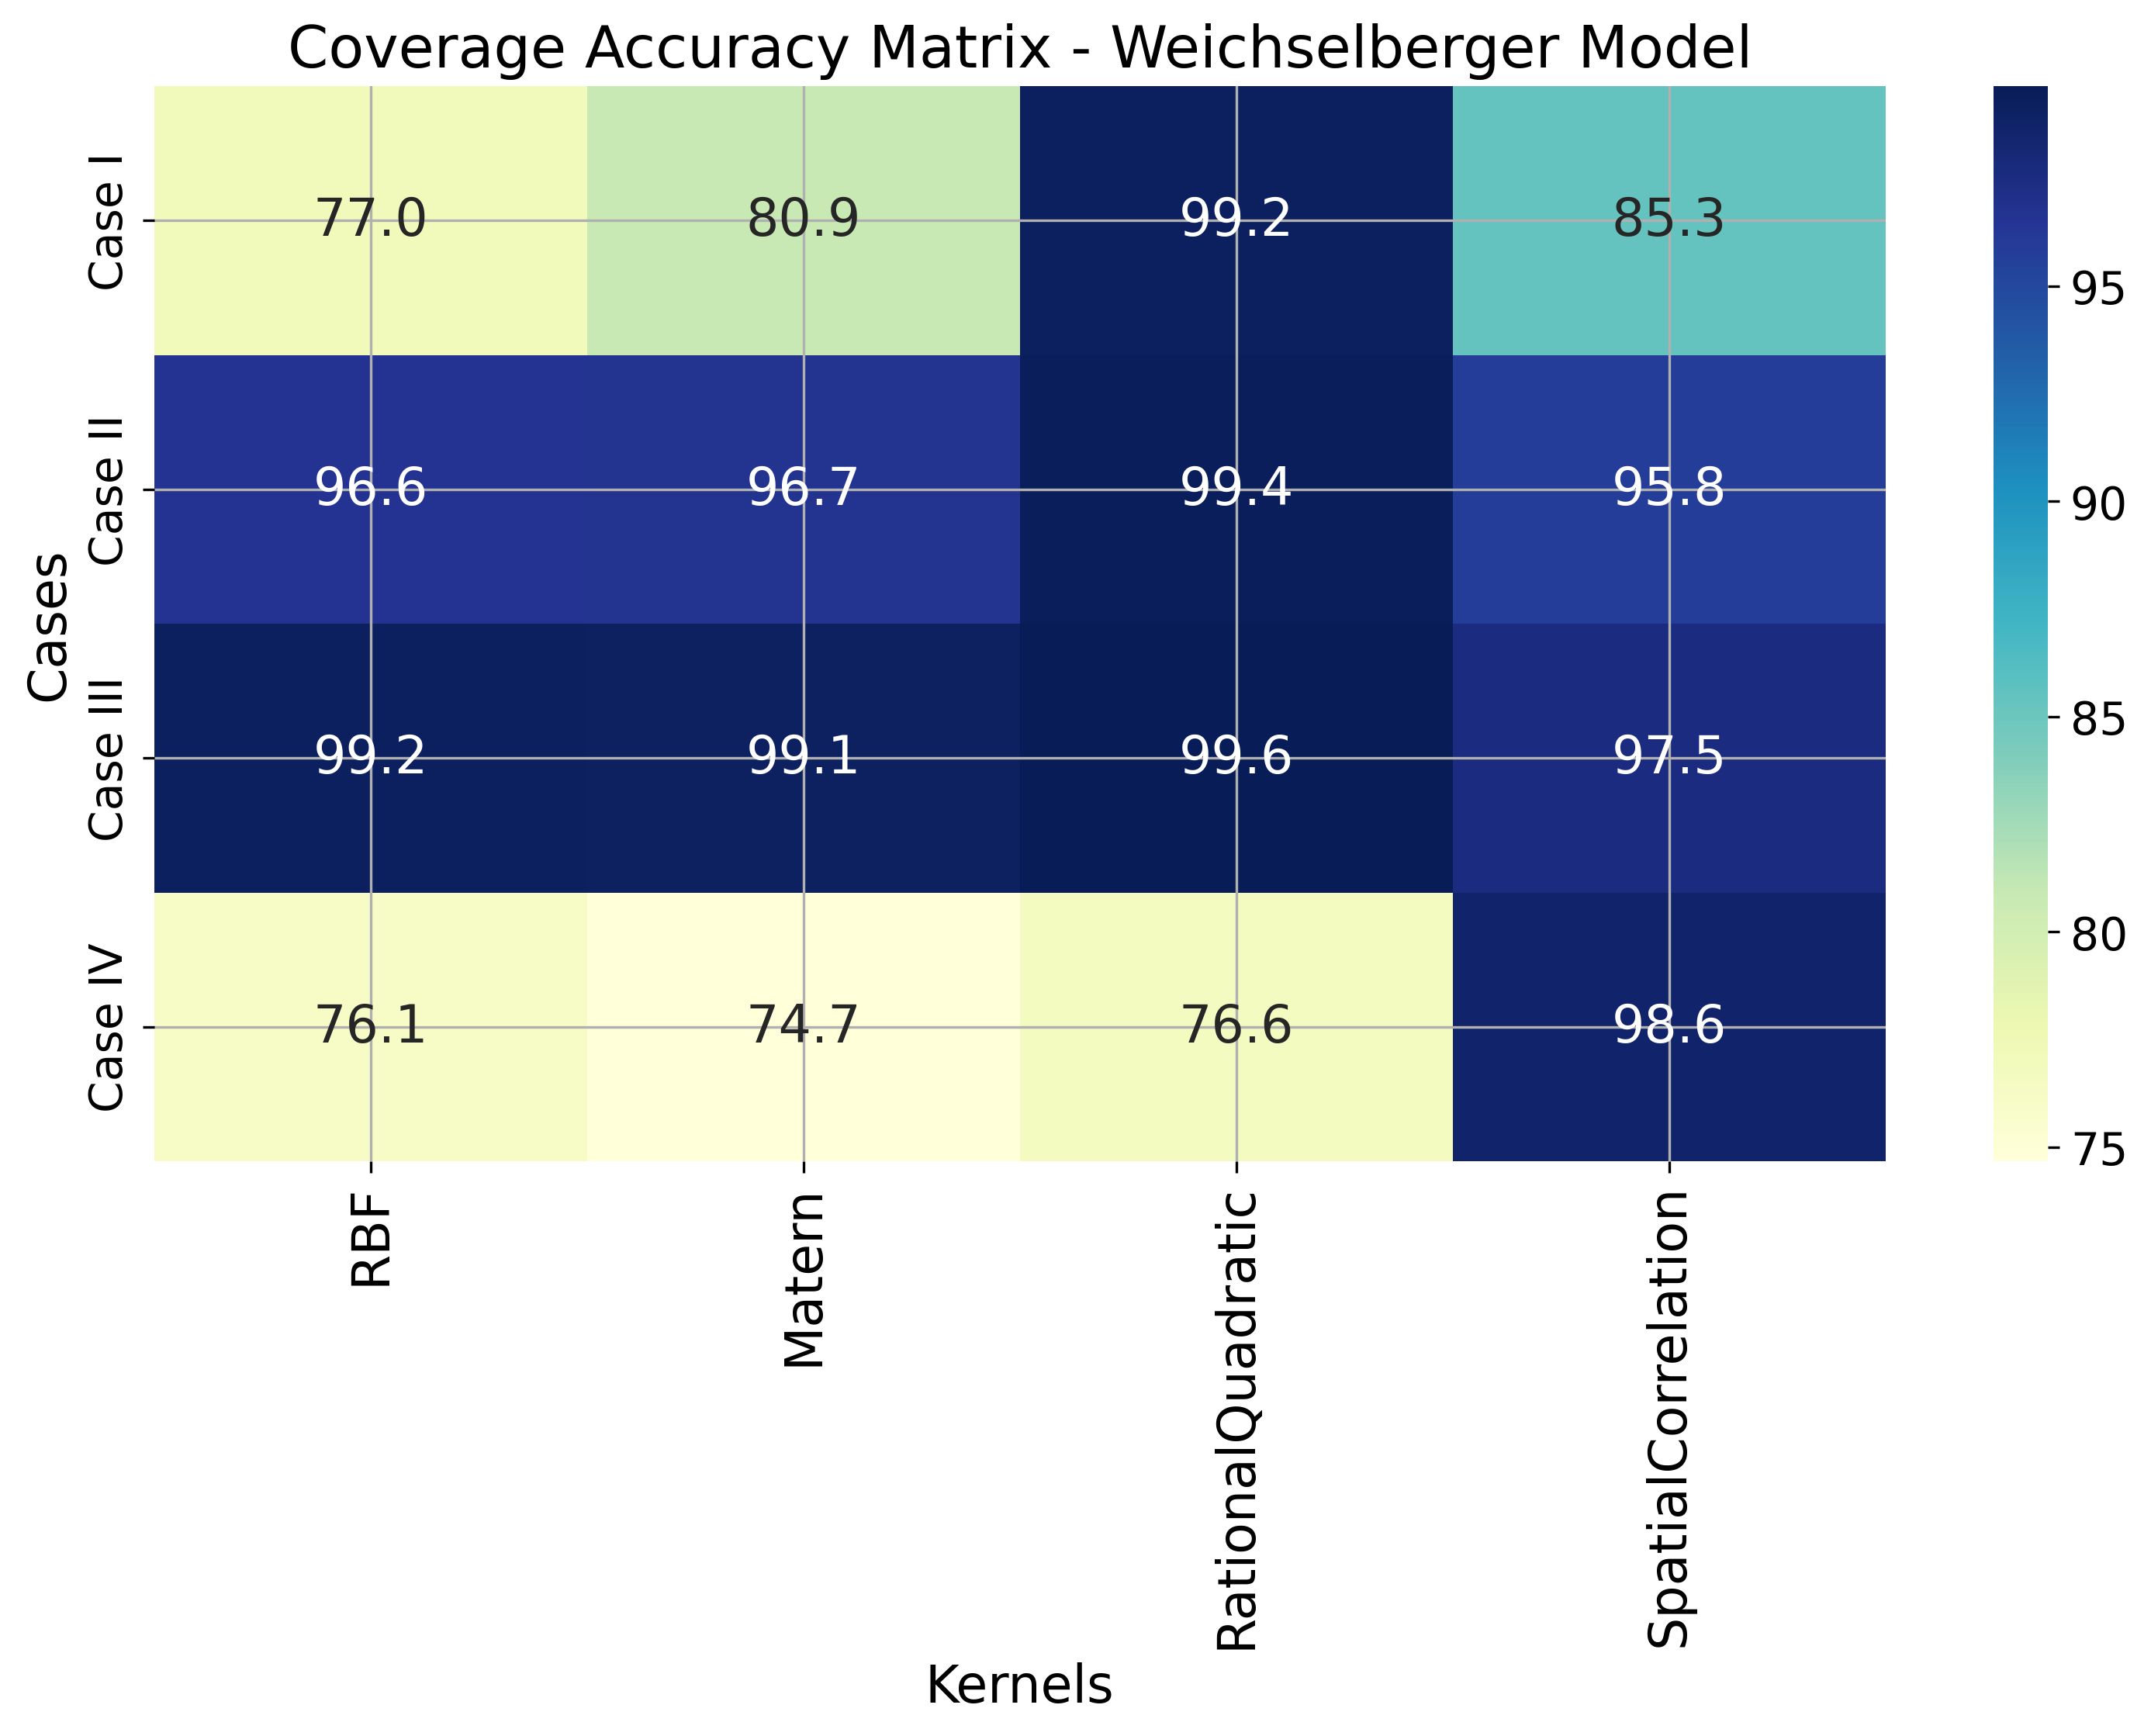

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams

rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 14,
    'figure.dpi': 300,
    'axes.grid': True
})

def load_channel_data():
    """Load and validate channel data from HDF5 file"""
    cases = ["Case I", "Case II", "Case III", "Case IV"]
    models = ["Kronecker", "Weichselberger"]
    #kernels = ['RBF', 'Matern', 'DotProduct','RationalQuadratic', 'ExpSineSquared','SpatialCorrelation']
    kernels = ['RBF', 'Matern','RationalQuadratic','SpatialCorrelation']

    data = {model: {case: {} for case in cases} for model in models}

    with h5py.File('channel_models.h5', 'r') as f:
        for model in models:
            for case in cases:
                # Load original channel data
                data[model][case]['H_true'] = np.array(
                    f[case][model]['Original']['H'][:],
                    dtype=np.complex128
                ).flatten()

                # Load predictions and uncertainties
                for kernel in kernels:
                    data[model][case][kernel] = {
                        'H_pred': np.array(
                            f[case][model][kernel]['H'][:],
                            dtype=np.complex128
                        ).flatten(),
                        'std': np.array(
                            f[case][model][kernel]['std'][:],
                            dtype=np.float64
                        ).flatten()
                    }
    return data, cases, models, kernels

def calculate_joint_coverage(H_true, H_pred, std):
    """Calculate joint complex value coverage with vectorized operations"""
    real_true = np.real(H_true)
    imag_true = np.imag(H_true)
    real_pred = np.real(H_pred)
    imag_pred = np.imag(H_pred)

    # Vectorized boundary calculations
    real_lower = real_pred - 1.96*std
    real_upper = real_pred + 1.96*std
    imag_lower = imag_pred - 1.96*std
    imag_upper = imag_pred + 1.96*std

    # Vectorized coverage check
    coverage_mask = (
        (real_true >= real_lower) &
        (real_true <= real_upper) &
        (imag_true >= imag_lower) &
        (imag_true <= imag_upper)
    )
    return np.mean(coverage_mask) * 100

def plot_model_coverage(model, data, cases, kernels):
    """Create comprehensive coverage plot for a single model"""
    #fig, ax = plt.subplots(figsize=(14, 7))
    fig, ax = plt.subplots(figsize=(9, 5))
    colors = plt.cm.tab10(np.linspace(0, 1, len(kernels)))

    # Calculate bar positions
    bar_width = 0.18
    case_positions = np.arange(len(cases)) * (len(kernels)*bar_width + 0.5)

    for case_idx, case in enumerate(cases):
        case_data = data[model][case]
        H_true = case_data['H_true']

        # Calculate coverage for all kernels in this case
        coverages = [
            calculate_joint_coverage(
                H_true,
                case_data[kernel]['H_pred'],
                case_data[kernel]['std']
            )
            for kernel in kernels
        ]

        # Plot bars for current case
        x = case_positions[case_idx] + np.arange(len(kernels)) * bar_width
        bars = ax.bar(x, coverages, bar_width, color=colors, edgecolor='white')

        # Add value labels
        for xi, val in zip(x, coverages):
            ax.text(xi, val*0.8, f'{val:.1f}%',
                    ha='center', va='bottom', rotation=90, fontsize=12,  fontweight='bold')

    # Formatting
    ax.set_xticks(case_positions + (len(kernels)-1)*bar_width/2)
    ax.set_xticklabels([f'Case {case.split()[-1]}' for case in cases])
    ax.set_ylabel('95% Confidence Coverage (%)')
    ax.set_ylim(50, 100)
    # ax.axhline(95, color='red', linestyle='--', alpha=0.7, label='Ideal Coverage')

    # Create unified legend
    legend_elements = [
        plt.Rectangle((0,0),1,1, fc=color, ec='w', label=kernel)
        for color, kernel in zip(colors, kernels)
    ]
    ax.legend(handles=legend_elements, loc='upper right',
             bbox_to_anchor=(0.575, 0.52), title='Legends: Kernels')

    plt.title(f'Joint Complex Value Coverage - {model} Model\n')
    plt.tight_layout()
    plt.savefig(f'Joint_Coverage_{model}.pdf', bbox_inches='tight')
    plt.show()
    #plt.close()

def plot_accuracy_heatmaps(data, models, cases, kernels):
    """Create heatmap visualizations of coverage accuracy"""
    for model in models:
        plt.figure(figsize=(12, 6))
        accuracy_matrix = np.zeros((len(cases), len(kernels)))

        for case_idx, case in enumerate(cases):
            case_data = data[model][case]
            H_true = case_data['H_true']

            for kernel_idx, kernel in enumerate(kernels):
                accuracy_matrix[case_idx, kernel_idx] = calculate_joint_coverage(
                    H_true,
                    case_data[kernel]['H_pred'],
                    case_data[kernel]['std']
                )

        sns.heatmap(
            accuracy_matrix,
            annot=True,
            fmt=".1f",
            cmap="YlGnBu",
            xticklabels=kernels,
            yticklabels=[f'Case {c.split()[-1]}' for c in cases]
        )

        plt.title(f'Coverage Accuracy Matrix - {model} Model')
        plt.xlabel('Kernels')
        plt.ylabel('Cases')
        plt.savefig(f'Accuracy_Matrix_{model}.png', bbox_inches='tight')
        plt.show()
        #plt.close()

# Main execution
if __name__ == "__main__":
    channel_data, cases, models, kernels = load_channel_data()

    # Generate coverage plots
    for model in models:
        plot_model_coverage(model, channel_data, cases, kernels)

    # Generate accuracy heatmaps
    plot_accuracy_heatmaps(channel_data, models, cases, kernels)

## Step 4(a): The NMSE b/w the predicted and true channel in dB

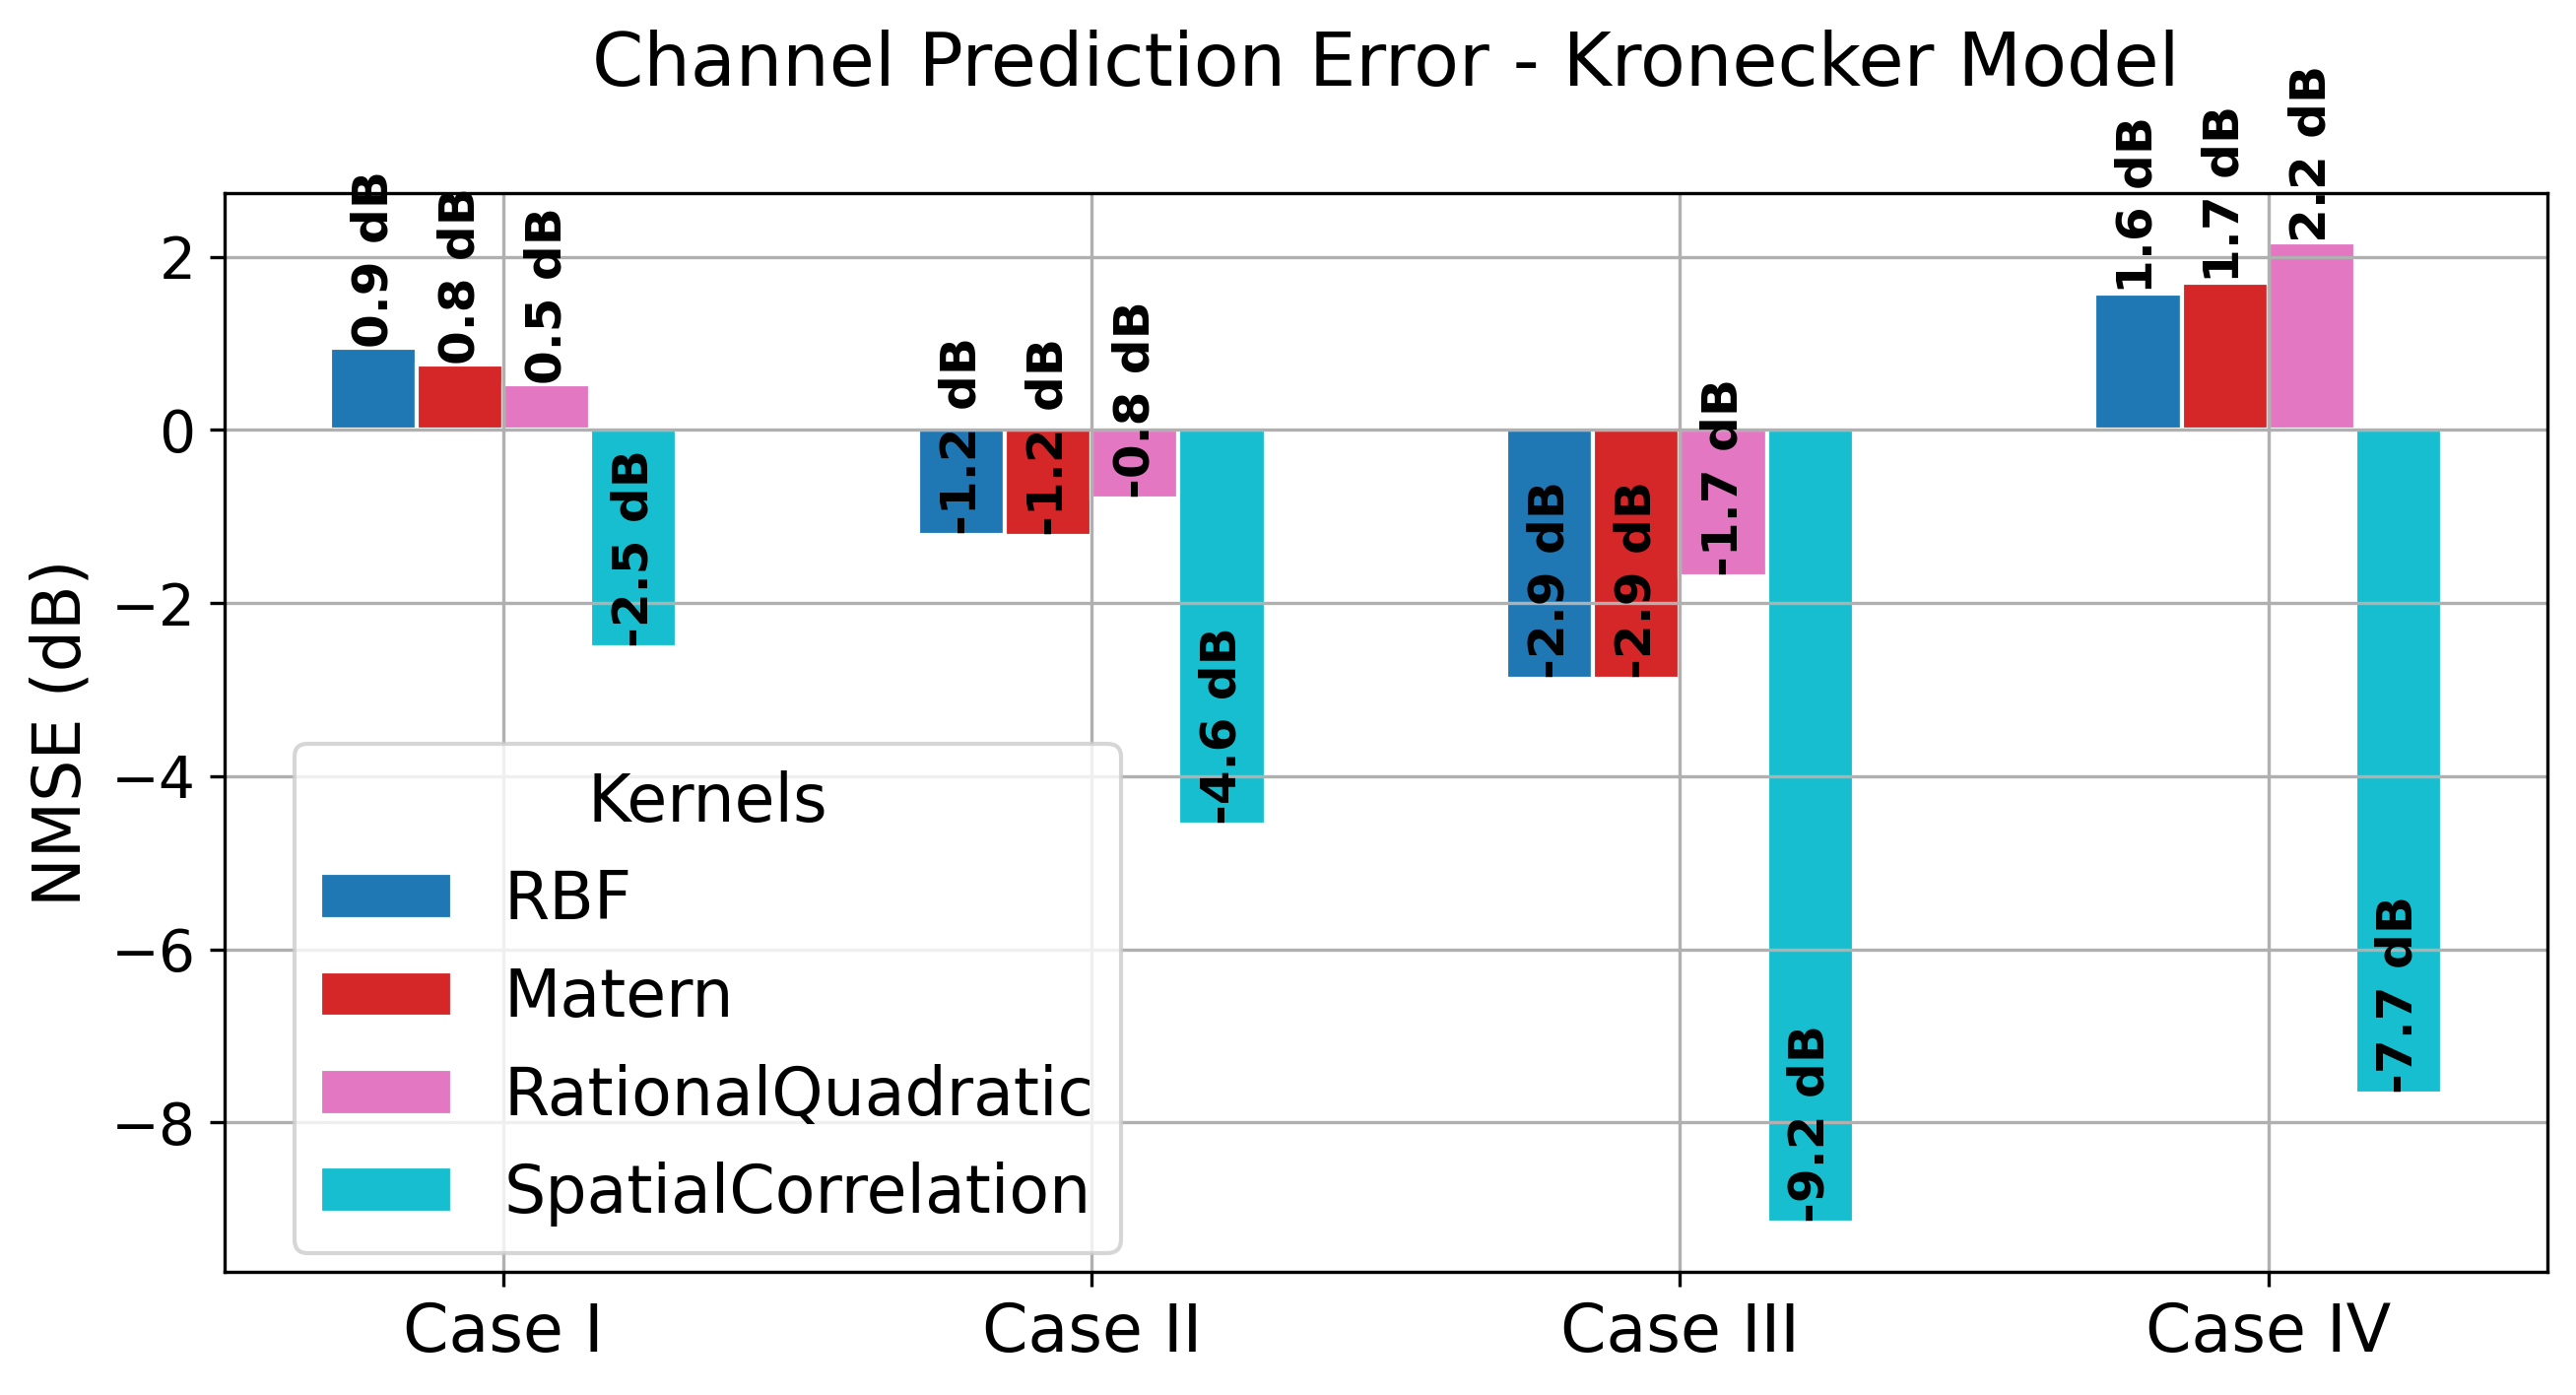

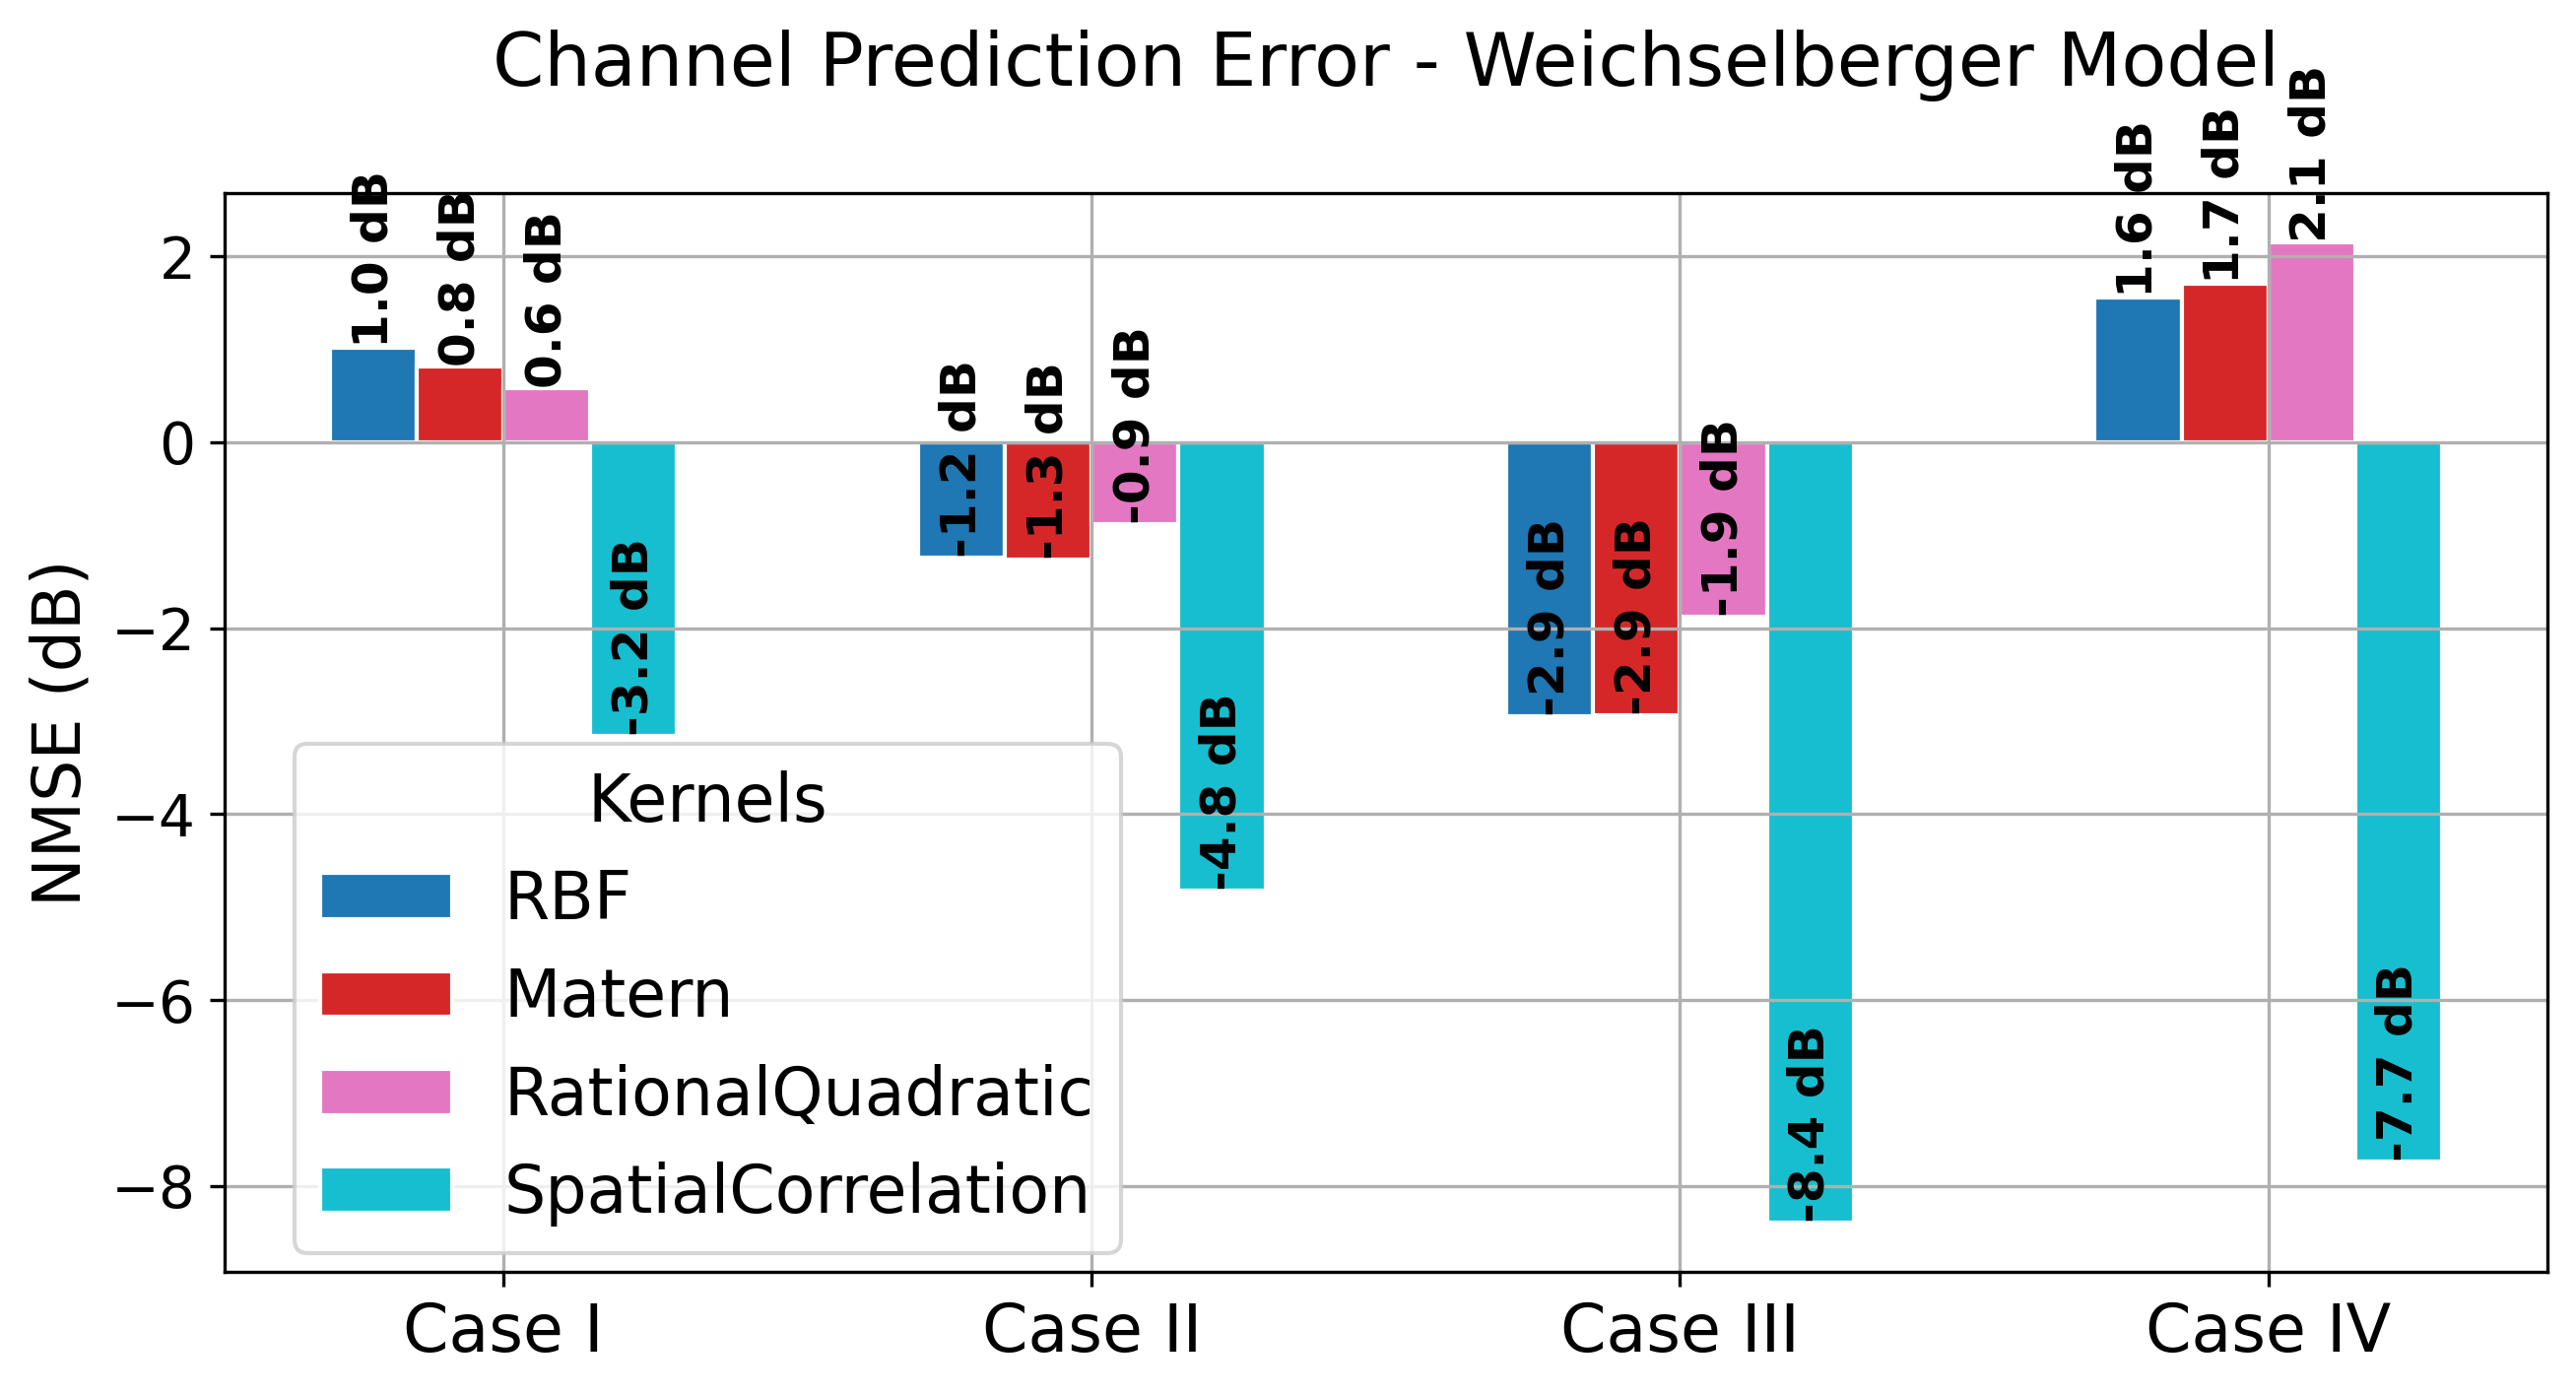

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Configure plot aesthetics
rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 14,
    'figure.dpi': 300,
    'axes.grid': True
})

def calculate_nmse(H_true, H_pred):
    """Calculate Normalized Mean Squared Error with complex handling"""
    numerator = np.mean(np.abs(H_true - H_pred)**2)
    denominator = np.mean(np.abs(H_true)**2)
    return 10 * np.log10(numerator / denominator)  # Convert to dB scale

def plot_nmse_comparison(models, cases, kernels):
    """Create comprehensive NMSE comparison plots"""
    with h5py.File('channel_models.h5', 'r') as f:
        for model in models:
            #fig, ax = plt.subplots(figsize=(14, 7))
            fig, ax = plt.subplots(figsize=(9, 5))
            colors = plt.cm.tab10(np.linspace(0, 1, len(kernels)))

            # Calculate bar positions
            bar_width = 0.18
            case_positions = np.arange(len(cases)) * (len(kernels)*bar_width + 0.5)

            for case_idx, case in enumerate(cases):
                # Load original channel data
                H_true = np.array(f[case][model]['Original']['H'][:],
                              dtype=np.complex128).flatten()

                # Calculate NMSE for all kernels
                nmse_values = []
                for kernel in kernels:
                    H_pred = np.array(f[case][model][kernel]['H'][:],
                                  dtype=np.complex128).flatten()
                    nmse = calculate_nmse(H_true, H_pred)
                    nmse_values.append(nmse)

                # Plot bars for current case
                x = case_positions[case_idx] + np.arange(len(kernels)) * bar_width
                bars = ax.bar(x, nmse_values, bar_width, color=colors, edgecolor='white')

                # Add value labels
                for xi, val in zip(x, nmse_values):
                    ax.text(xi, val + 0.00000009, f'{val:.1f} dB',
                           ha='center', va='bottom', rotation=90, fontsize=12, fontweight='bold')

            # Formatting
            ax.set_xticks(case_positions + (len(kernels)-1)*bar_width/2)
            ax.set_xticklabels([f'Case {case.split()[-1]}' for case in cases])
            ax.set_ylabel('NMSE (dB)')
            #ax.set_title(f'Channel Estimation Error - {model} Model\n', fontweight='bold')
            ax.set_title(f'Channel Prediction Error - {model} Model\n',)

            # Create legend
            legend_elements = [plt.Rectangle((0,0),1,1, fc=color, ec='w', label=kernel)
                              for color, kernel in zip(colors, kernels)]
            ax.legend(handles=legend_elements, loc='upper right',
                     bbox_to_anchor=(0.4, 0.52), title='Kernels')

            plt.tight_layout()
            plt.savefig(f'NMSE_Comparison_{model}.pdf', bbox_inches='tight')
            plt.show()
            #plt.close()

# Main execution
if __name__ == "__main__":
    cases = ["Case I", "Case II", "Case III", "Case IV"]
    models = ["Kronecker", "Weichselberger"]
    #kernels = ['RBF', 'Matern', 'DotProduct','RationalQuadratic', 'ExpSineSquared','SpatialCorrelation']
    kernels = ['RBF', 'Matern','RationalQuadratic','SpatialCorrelation']

    plot_nmse_comparison(models, cases, kernels)

## Step 4(b): The NMSE b/w the predicted and true channel in log sacle

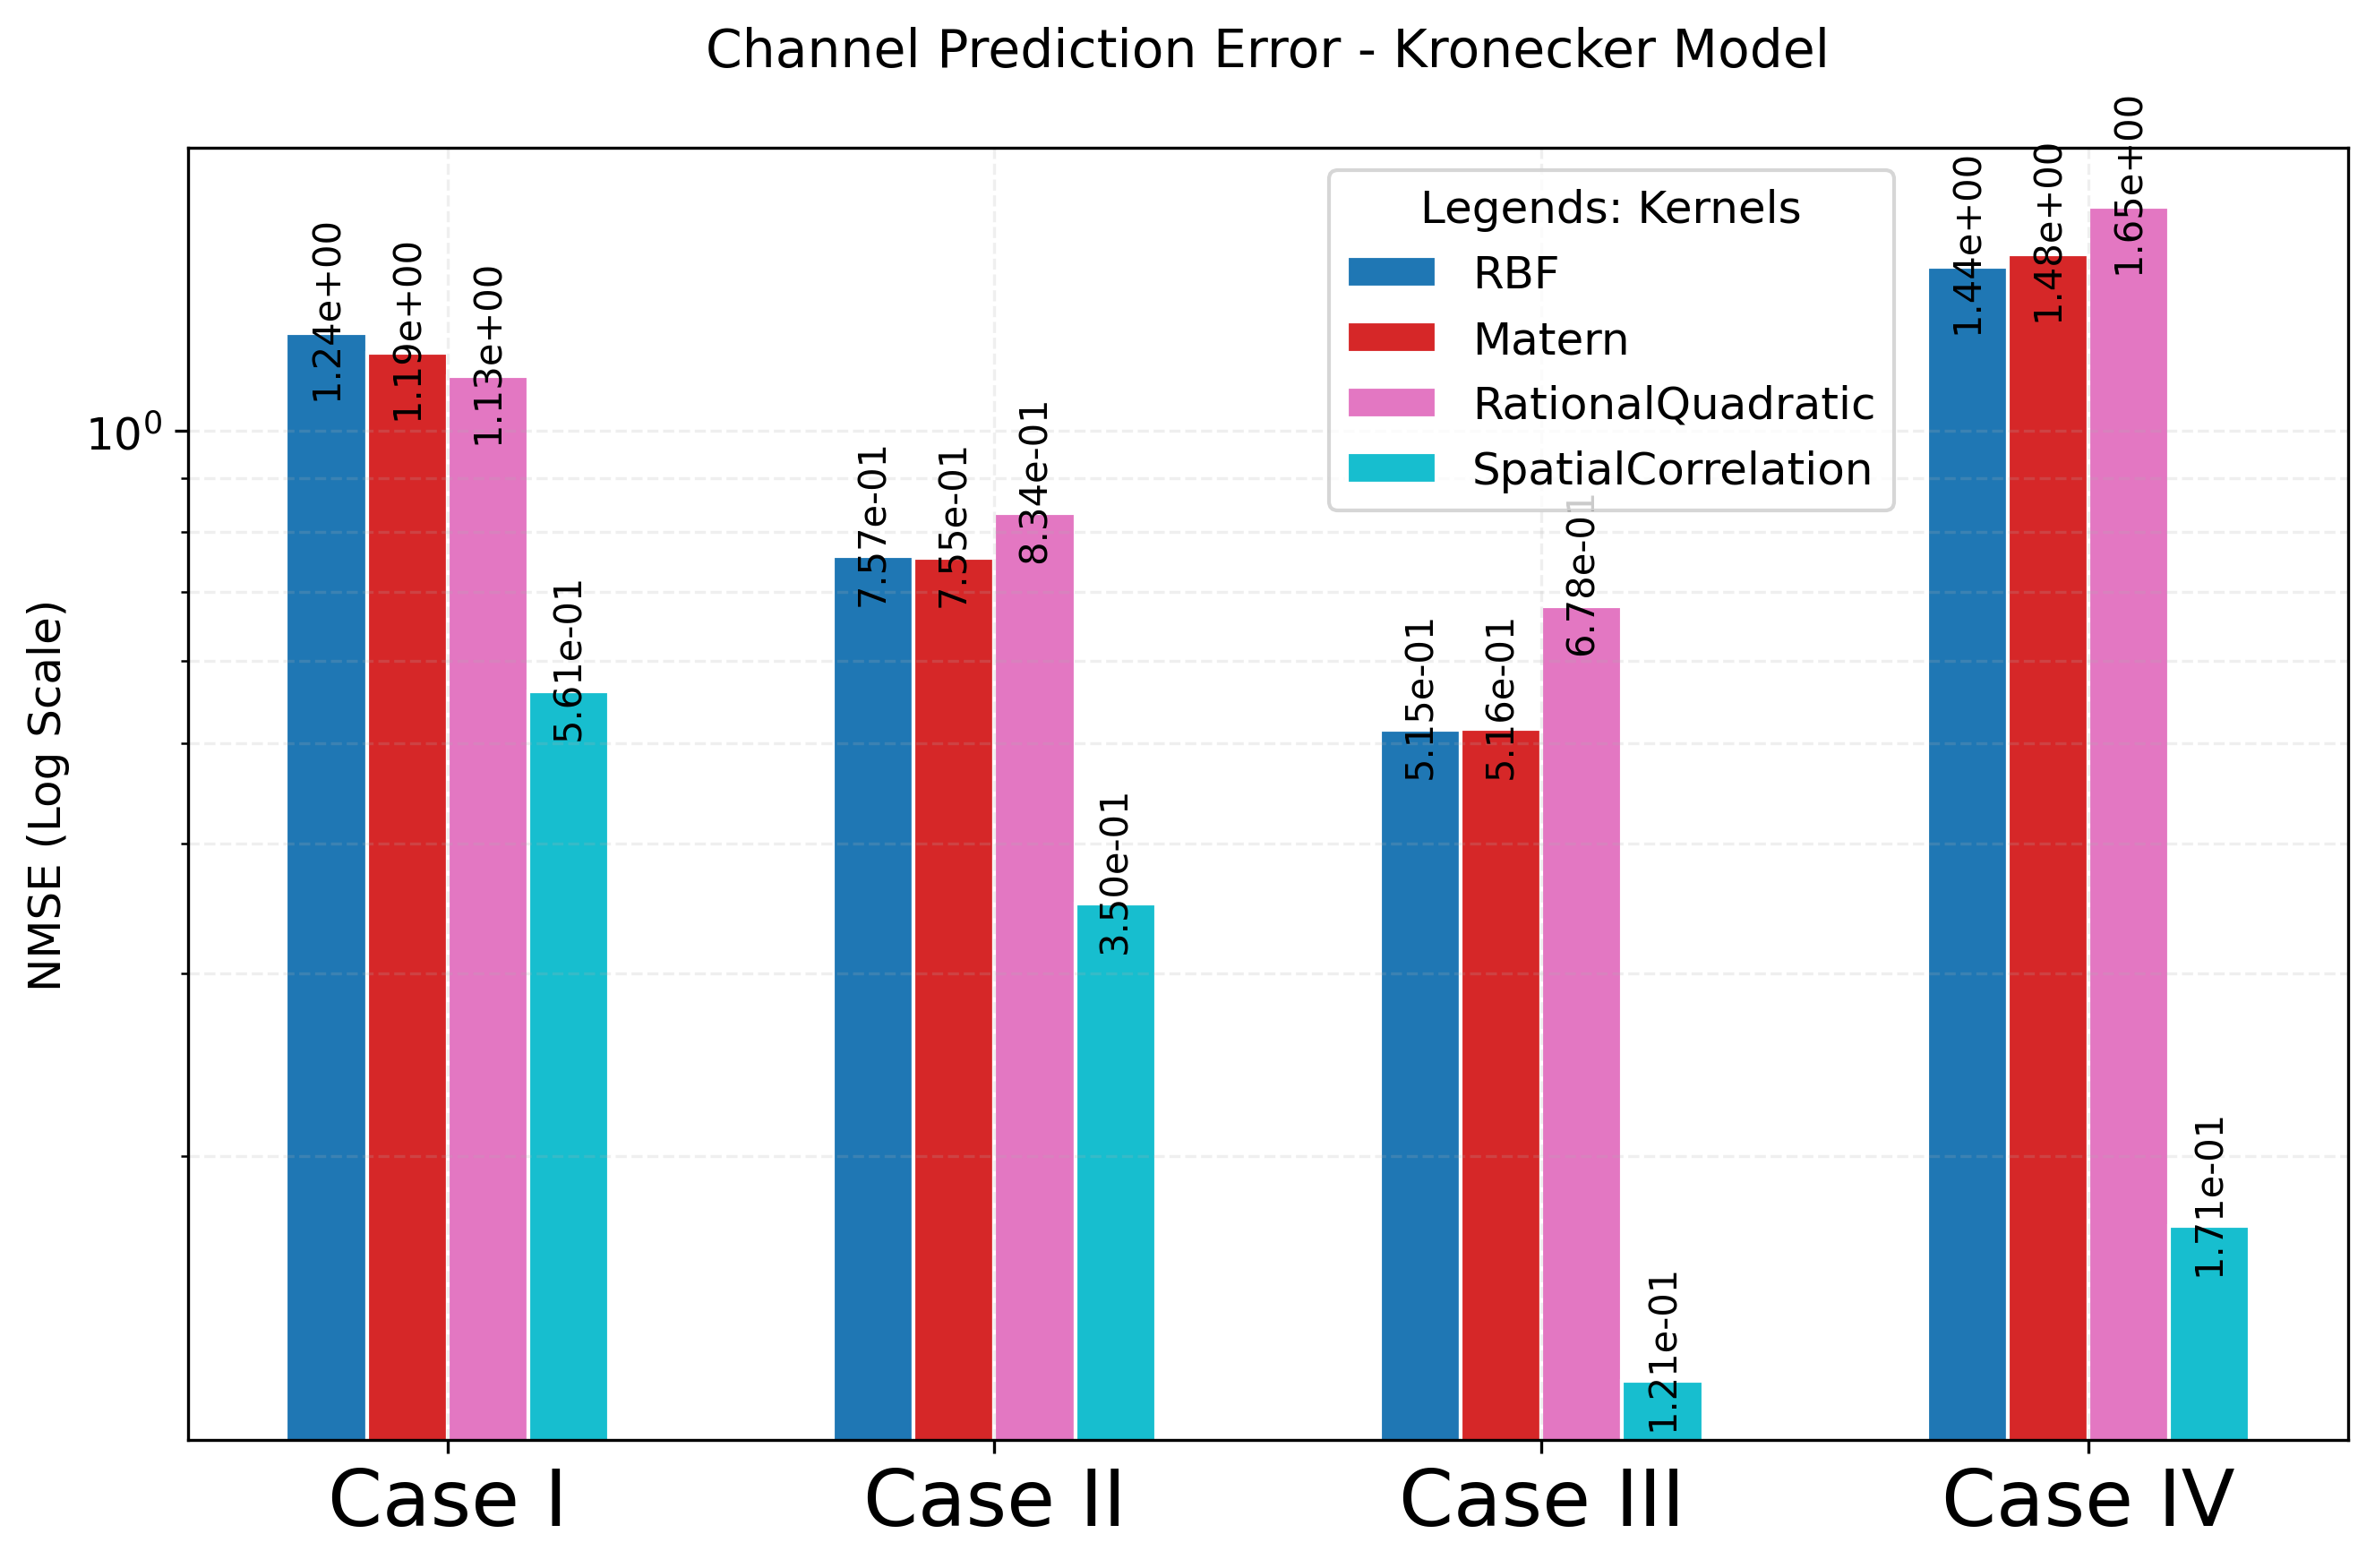

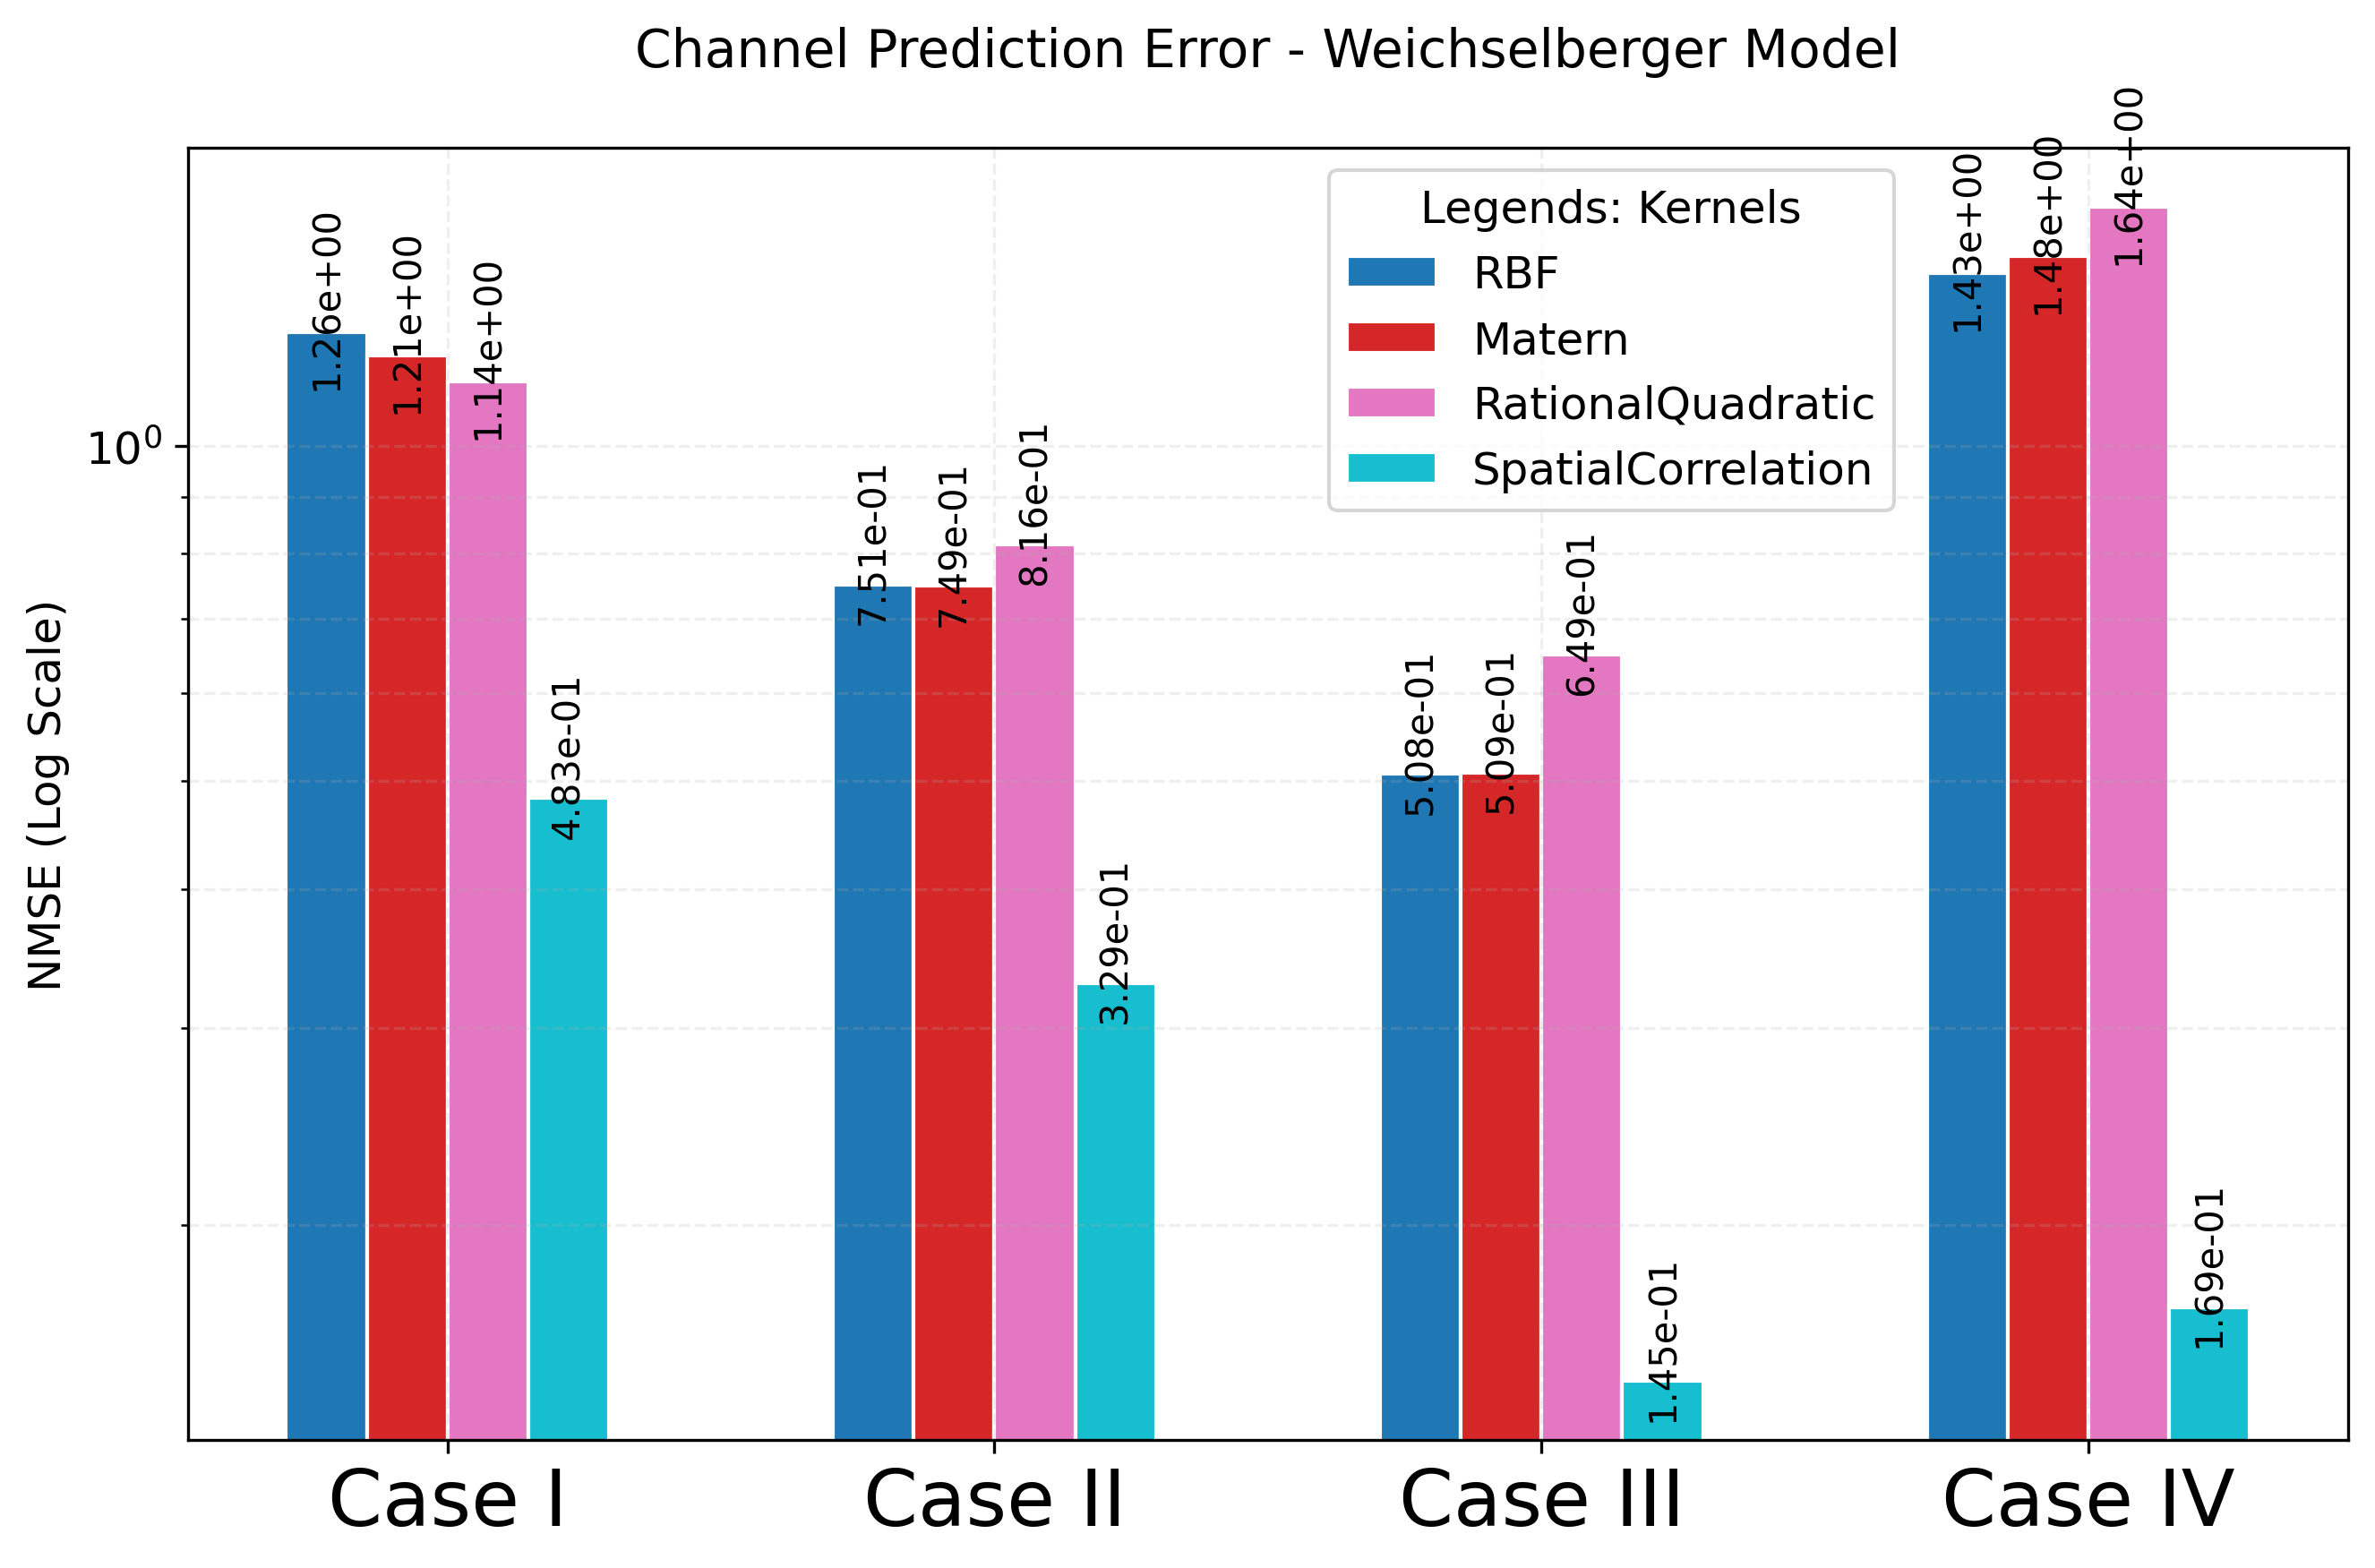

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Configure plot aesthetics
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 21,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'axes.grid': True,
    'grid.alpha': 0.3
})

def calculate_nmse(H_true, H_pred):
    """Calculate Normalized Mean Squared Error without dB conversion"""
    numerator = np.mean(np.abs(H_true - H_pred)**2)
    denominator = np.mean(np.abs(H_true)**2)
    return numerator / denominator  # NMSE in linear scale

def plot_nmse_comparison(models, cases, kernels):
    """Create comprehensive NMSE comparison plots with log scale"""
    with h5py.File('channel_models.h5', 'r') as f:
        for model in models:
            #fig, ax = plt.subplots(figsize=(14, 7))
            fig, ax = plt.subplots(figsize=(9, 6))
            colors = plt.cm.tab10(np.linspace(0, 1, len(kernels)))

            # Calculate bar positions
            bar_width = 0.18
            case_positions = np.arange(len(cases)) * (len(kernels) * bar_width + 0.5)

            for case_idx, case in enumerate(cases):
                # Load original channel data
                H_true = np.array(f[case][model]['Original']['H'][:],
                                  dtype=np.complex128).flatten()

                # Calculate NMSE for all kernels in linear scale
                nmse_values = []
                for kernel in kernels:
                    H_pred = np.array(f[case][model][kernel]['H'][:],
                                      dtype=np.complex128).flatten()
                    nmse = calculate_nmse(H_true, H_pred)
                    nmse_values.append(nmse)

                # Plot bars for current case
                x = case_positions[case_idx] + np.arange(len(kernels)) * bar_width
                bars = ax.bar(x, nmse_values, bar_width, color=colors, edgecolor='white')

                # Add value labels
                for xi, val in zip(x, nmse_values):
                    ax.text(xi, val * 1.3, f'{val:.2e}',
                            ha='center', va='top', rotation=90,
                            #fontweight='bold',
                            fontsize=10)

            # Formatting
            ax.set_xticks(case_positions + (len(kernels)-1) * bar_width / 2)
            ax.set_xticklabels([f'Case {case.split()[-1]}' for case in cases])
            ax.set_ylabel('NMSE (Log Scale)')
            ax.set_yscale('log')  # Set y-axis to log scale
            #ax.set_title(f'Channel Estimation Error - {model} Model\n', fontweight='bold')
            ax.set_title(f'Channel Prediction Error - {model} Model\n',)

            # Create legend
            legend_elements = [plt.Rectangle((0,0),1,1, fc=color, ec='w', label=kernel)
                               for color, kernel in zip(colors, kernels)]
            ax.legend(handles=legend_elements, loc='upper right',
                      bbox_to_anchor=(0.8, 1), title='Legends: Kernels', fontsize = 12)

            plt.tight_layout()
            ax.grid(True, which='both', linestyle='--', alpha=0.2)
            plt.savefig(f'NMSE_Comparison_{model}.pdf', bbox_inches='tight')
            plt.show()

# Main execution
if __name__ == "__main__":
    cases = ["Case I", "Case II", "Case III", "Case IV"]
    models = ["Kronecker", "Weichselberger"]
    kernels = ['RBF', 'Matern','RationalQuadratic','SpatialCorrelation']

    plot_nmse_comparison(models, cases, kernels)